In [5]:
import glob
import pandas as pd
from datetime import datetime
import os
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from tqdm import tqdm

# 0. Load Data

In [6]:
output_dir = '../Data/Samsung/samsung-security-updates'

# List to hold dataframes
dfs = []

# List all CSVs in the directory
csv_files = [f for f in os.listdir(output_dir) if f.endswith('.csv')]

# Iterate over each file with progress bar
for file in tqdm(csv_files, desc="Loading CSVs"):
    # Read the CSV and append to the list
    dfs.append(pd.read_csv(f"{output_dir}/{file}"))

# Concatenate all dataframes in the list
df_samsung = pd.concat(dfs, ignore_index=True)

Loading CSVs: 100%|█████████████████████████████| 40/40 [00:03<00:00, 10.06it/s]


## Samsung-All

In [7]:
import pandas as pd
import datetime
import matplotlib.dates as mdates
import numpy as np

df_knox_models = pd.read_csv('../Data/Samsung/knox-models-all.csv')
df_csc = pd.read_csv('../Data/Samsung/CSC-list.csv')

df_samsung["security_patch_level"] = df_samsung["security_patch_level"].astype("datetime64")
df_samsung["release_date"] = df_samsung["release_date"].astype("datetime64")


d = []
unique_ids = df_samsung['id'].unique()

# Wrap the loop with tqdm for progress bar
pbar = tqdm(unique_ids, desc="Processing Records", dynamic_ncols=True)

for idx, i in enumerate(pbar):
    
    #get the model and CSC code from the unique pair id
    [model,CSC] = i.split('/')
    
    #extract carrier_country from CSC dataset
    cc= df_csc[df_csc['CSC']==CSC]['carrier/country'].to_list()
    carrier_country = cc[0]
    
    #extract carrier from CSC dataset
    car = df_csc[df_csc['CSC']==CSC]['carrier'].to_list()
    carrier = car[0]
    
    #extract country from CSC dataset
    cou = df_csc[df_csc['CSC']==CSC]['country'].to_list()
    country = cou[0]
    
    #extract ISO code from CSC dataset
    iso = df_csc[df_csc['CSC']==CSC]['iso_code'].to_list()
    iso_code = iso[0]
    
    #extract region from CSC dataset
    reg = df_csc[df_csc['CSC']==CSC]['region'].to_list()
    region = reg[0]
    
    #extract subregion from CSC dataset
    subreg = df_csc[df_csc['CSC']==CSC]['subregion'].to_list()
    subregion = subreg[0]

    #extract knox device from model
    k = df_knox_models.loc[df_knox_models['model']==model,'device'].to_list()
    if len(k) == 1:
        device = k[0]
    else:
        device = ''
        
    #extract device type knox devices
    dt = df_knox_models.loc[df_knox_models['model']==model,'device_type'].to_list()
    if len(dt) == 1:
        device_type= dt[0]
    else:
        device_type = ''

    #CALCULATE FEATURES
    #filter the dataset for the unique pair
    df_test = df_samsung[df_samsung['id']==i]
    
    #get the url
    url = 'https://doc.samsungmobile.com/' + i + '/doc.html'
    
    #extract all unique android version used for the unique pair
    android_versions = df_test['android_version'].unique()
    first_OS = df_test.sort_values('release_date',ascending=False)['android_version'].iat[-1]
    last_OS = df_test.sort_values('release_date',ascending=False)['android_version'].iat[0]

    #extract SPLs for the unique pair
    SPL_dates = df_test['security_patch_level']
    
    #calculate other fetures from SPL array for for the unique pair
    first_SPL = SPL_dates.min()
    last_SPL = SPL_dates.max()
    SPL_duration = SPL_dates.max()- SPL_dates.min()
    SPL_count = len(SPL_dates)
    SPL_freq = SPL_duration.days/SPL_count
    
    #extract Release dates for the unique pair
    release_dates = df_test['release_date']
    
    #calculate other fetures from ReleaseDates array for for the unique pair
    first_release_date = release_dates.min()
    last_release_date = release_dates.max()
    release_date_duration = release_dates.max() - release_dates.min()
    release_count = len(release_dates)
    avg_release_freq = release_date_duration.days/release_count
    
    #calculate avg delay in the release dates and SPL dates
    avg_release_delay = (df_test['release_date']-df_test['security_patch_level']).mean().days
    
    
    a = df_knox_models.loc[df_knox_models.model==model,'AER'].to_list()
    
    if len(a) >= 1:
        aer = a[0]
    else:
        aer = False
        
    p = df_knox_models.loc[df_knox_models.model==model,'platform'].to_list()
    
    if len(p) >= 1:
        platform = p[0]
    else:
        platform = 'No-Info'
        
    
    #create the final array
    d.append({'id': i,
             'device': device,
             'model': model,
             'CSC': CSC,
             'device_type': device_type,
             'aer': aer,
             'platform': platform,
             'carrier_country': carrier_country,
             'carrier': carrier,
             'country': country,
             'iso_code': iso_code,
             'region': region,
             'subregion': subregion,
             'android_versions': android_versions,
             'android_versions_str': ','.join(android_versions),
             'android_versions_count': len(android_versions),
             'first_OS': first_OS,
             'last_OS': last_OS,
             'first_SPL': first_SPL,
             'last_SPL': last_SPL,
             'SPL_duration': SPL_duration,
             'release_date_duration': release_date_duration,
             'SPL_count': SPL_count,
             'release_count': release_count,
             'SPL_freq': SPL_freq,
             'avg_release_freq': avg_release_freq,
             'first_release_date': first_release_date,
             'last_release_date': last_release_date,
             'avg_release_delay': avg_release_delay,
             'url': url})


df_final_samsung = pd.DataFrame(d)

df_final_samsung.to_csv('../Data/Samsung/Samsung_security_updates_history_features.csv',index=False)

df_final_samsung.head()


Processing Records: 100%|█████████████████| 21461/21461 [07:44<00:00, 46.24it/s]


,id,device,model,CSC,device_type,aer,platform,carrier_country,carrier,country,...,SPL_duration,release_date_duration,SPL_count,release_count,SPL_freq,avg_release_freq,first_release_date,last_release_date,avg_release_delay,url
0,SM-A530F/ORO,Galaxy A8 (2018),SM-A530F,ORO,smartphone,False,Knox,Romania (Orange),Orange,Romania,...,1219 days,1330 days,34,34,35.852941,39.117647,2018-04-27,2021-12-17,38.0,https://doc.samsungmobile.com/SM-A530F/ORO/doc...
1,SM-A530F/ORS,Galaxy A8 (2018),SM-A530F,ORS,smartphone,False,Knox,Slovakia,No-carrier,Slovakia,...,1219 days,1330 days,34,34,35.852941,39.117647,2018-04-27,2021-12-17,39.0,https://doc.samsungmobile.com/SM-A530F/ORS/doc...
2,SM-A530F/ORX,Galaxy A8 (2018),SM-A530F,ORX,smartphone,False,Knox,Slovakia,No-carrier,Slovakia,...,1219 days,1420 days,40,40,30.475000,35.500000,2018-01-16,2021-12-06,29.0,https://doc.samsungmobile.com/SM-A530F/ORX/doc...
3,SM-A530F/PAK,Galaxy A8 (2018),SM-A530F,PAK,smartphone,False,Knox,Pakistan (PAK),PAK,Pakistan,...,1219 days,1457 days,36,36,33.861111,40.472222,2018-01-24,2022-01-20,30.0,https://doc.samsungmobile.com/SM-A530F/PAK/doc...
4,SM-A530F/PAN,Galaxy A8 (2018),SM-A530F,PAN,smartphone,False,Knox,Hungary (Telenor),Telenor,Hungary,...,1219 days,1309 days,22,22,55.409091,59.500000,2018-05-04,2021-12-03,36.0,https://doc.samsungmobile.com/SM-A530F/PAN/doc...


## Samsung-Monthly

In [9]:
output_dir = '../Data/Samsung/samsung-security-updates'

# List to hold dataframes
dfs = []

# List all CSVs in the directory
csv_files = [f for f in os.listdir(output_dir) if f.endswith('.csv')]

# Iterate over each file with progress bar
for file in tqdm(csv_files, desc="Loading CSVs"):
    # Read the CSV and append to the list
    dfs.append(pd.read_csv(f"{output_dir}/{file}"))

# Concatenate all dataframes in the list
df_samsung_v2 = pd.concat(dfs, ignore_index=True)

Loading CSVs: 100%|█████████████████████████████| 40/40 [00:03<00:00, 10.61it/s]


In [10]:
#df_v2 = pd.read_csv('../Data/security_update_history_v2.csv') 
#df_samsung_v2 = pd.read_csv('../Data/Samsung/Samsung-security-updates-history_all_v3.csv') 
df_csc = pd.read_csv('../Data/Samsung/CSC-list.csv')
df_knox_models = pd.read_csv('../Data/Samsung/knox-models-all.csv')
df_timelines = pd.read_csv('../Data/Samsung/timelines_samsung_devices_v3.csv')

#drop if no release date
df_samsung_v2 = df_samsung_v2[~df_samsung_v2['release_date'].isnull()]

#convert the string values into timedate values
df_samsung_v2["security_patch_level"] = df_samsung_v2["security_patch_level"].astype("datetime64")
df_samsung_v2["release_date"] = df_samsung_v2["release_date"].astype("datetime64")
df_timelines[['monthly_start','monthly_end']] = df_timelines[['monthly_start','monthly_end']].apply(pd.to_datetime)
df_timelines[['monthly_duration']] = df_timelines[['monthly_duration']].apply(pd.to_timedelta)

#filter out the incomplete and zero monthly support duration
monthly_timelines = df_timelines[(~(df_timelines['monthly_duration'].dt.days==0))&(~df_timelines['monthly_duration'].isnull())]
monthly_devices = monthly_timelines['device'].unique()

df_monthly = pd.DataFrame()
for device in monthly_devices[:]:
    
    monthly_start =df_timelines.loc[df_timelines.device==device,'monthly_start'].item()
    monthly_end =df_timelines.loc[df_timelines.device==device,'monthly_end'].item()
    
    df_samsung_v2.loc[df_samsung_v2.device==device,'monthly_start'] = monthly_start
    df_samsung_v2.loc[df_samsung_v2.device==device,'monthly_end'] = monthly_end
    
    df_device = df_samsung_v2.loc[df_samsung_v2.device==device,:]
    df_device_filtered = df_device[(df_device['release_date']>monthly_start) & (df_device['release_date']<monthly_end)]
    df_monthly=pd.concat([df_monthly,df_device_filtered])
    
d_monthly = []
counter = 0

for i in df_monthly['id'].unique():
    df_test = df_monthly.loc[df_monthly['id']==i,:]
    [model,CSC] = i.split('/')
    
    #extract carrier_country from CSC dataset
    cc= df_csc[df_csc['CSC']==CSC]['carrier/country'].to_list()
    carrier_country = cc[0]
    #extract carrier from CSC dataset
    car = df_csc[df_csc['CSC']==CSC]['carrier'].to_list()
    carrier = car[0]
    #extract country from CSC dataset
    cou = df_csc[df_csc['CSC']==CSC]['country'].to_list()
    country = cou[0]
    #extract ISO code from CSC dataset
    iso = df_csc[df_csc['CSC']==CSC]['iso_code'].to_list()
    iso_code = iso[0]
    #extract region from CSC dataset
    reg = df_csc[df_csc['CSC']==CSC]['region'].to_list()
    region = reg[0]
    #extract subregion from CSC dataset
    subreg = df_csc[df_csc['CSC']==CSC]['subregion'].to_list()
    subregion = subreg[0]
    
    #extract device type knox devices
    dt = df_knox_models.loc[df_knox_models['model']==model,'device_type'].to_list()
    if len(dt) == 1:
        device_type= dt[0]
    else:
        device_type = ''
        
    #get the url
    url = 'https://doc.samsungmobile.com/' + i + '/doc.html'
    
    device = df_test.loc[df_test['id']==i,'device'].to_list()[0]
    
    #extract all unique android version used for the unique pair
    android_versions = df_test['android_version'].unique()
    first_OS = df_test.sort_values('release_date',ascending=False)['android_version'].iat[-1]
    last_OS = df_test.sort_values('release_date',ascending=False)['android_version'].iat[0]
    
    SPL_dates = df_test.loc[df_test['id']==i,'security_patch_level']
    #calculate other fetures from SPL array for for the unique pair
    first_SPL = SPL_dates.min()
    last_SPL = SPL_dates.max()
    SPL_duration = SPL_dates.max()- SPL_dates.min()
    SPL_count = len(SPL_dates)
    SPL_freq = SPL_duration.days/SPL_count
    
    release_dates = df_test.loc[df_test['id']==i,'release_date']
    #calculate other fetures from ReleaseDates array for for the unique pair
    first_release_date = release_dates.min()
    last_release_date = release_dates.max()
    release_date_duration = release_dates.max() - release_dates.min()
    release_count = len(release_dates)
    avg_release_freq = release_date_duration.days/release_count
    
    #calculate avg delay in the release dates and SPL dates
    avg_release_delay = (df_test['release_date']-df_test['security_patch_level']).mean().days

    a = df_knox_models.loc[df_knox_models.model==model,'AER'].to_list()
    
    if len(a) >= 1:
        aer = a[0]
    else:
        aer = False
        
    p = df_knox_models.loc[df_knox_models.model==model,'platform'].to_list()
    
    if len(p) >= 1:
        platform = p[0]
    else:
        platform = 'No-Info'
        
     
    #create the final array
    d_monthly.append({'id': i,
             'device': device,
             'model': model,
             'CSC': CSC,
             'device_type': device_type,
             'aer': aer,
             'platform': platform,
             'carrier_country': carrier_country,
             'carrier': carrier,
             'country': country,
             'iso_code': iso_code,
             'region': region,
             'subregion': subregion,
             'android_versions': android_versions,
             'android_versions_str': ','.join(android_versions),
             'android_versions_count': len(android_versions),
             'first_OS': first_OS,
             'last_OS': last_OS,
             'first_SPL': first_SPL,
             'last_SPL': last_SPL,
             'SPL_duration': SPL_duration,
             'release_date_duration': release_date_duration,
             'SPL_count': SPL_count,
             'release_count': release_count,
             'SPL_freq': SPL_freq,
             'avg_release_freq': avg_release_freq,
             'first_release_date': first_release_date,
             'last_release_date': last_release_date,
             'avg_release_delay': avg_release_delay,
             'url': url})
    counter = counter + 1
    print('Completed {} / {}'.format(counter,len(df_monthly['id'].unique())), end='\r')
    
df_final_samsung_monthly = pd.DataFrame(d_monthly)

df_final_samsung_monthly.head()   
    

,id,device,model,CSC,device_type,aer,platform,carrier_country,carrier,country,...,SPL_duration,release_date_duration,SPL_count,release_count,SPL_freq,avg_release_freq,first_release_date,last_release_date,avg_release_delay,url
0,SM-F900F/BGL,Galaxy Fold,SM-F900F,BGL,smartphone,False,Knox,Bulgaria,No-carrier,Bulgaria,...,973 days,985 days,33,33,29.484848,29.848485,2020-02-19,2022-10-31,16.0,https://doc.samsungmobile.com/SM-F900F/BGL/doc...
1,SM-F900F/BRI,Galaxy Fold,SM-F900F,BRI,smartphone,False,Knox,Taiwan,No-carrier,Taiwan,...,1035 days,1048 days,35,35,29.571429,29.942857,2019-12-18,2022-10-31,22.0,https://doc.samsungmobile.com/SM-F900F/BRI/doc...
2,SM-F900F/CHO,Galaxy Fold,SM-F900F,CHO,smartphone,False,Knox,Chile,No-carrier,Chile,...,1035 days,1034 days,36,36,28.750000,28.722222,2019-12-30,2022-10-29,24.0,https://doc.samsungmobile.com/SM-F900F/CHO/doc...
3,SM-F900F/COO,Galaxy Fold,SM-F900F,COO,smartphone,False,Knox,Colombia,No-carrier,Colombia,...,1035 days,1042 days,36,36,28.750000,28.944444,2019-12-19,2022-10-26,22.0,https://doc.samsungmobile.com/SM-F900F/COO/doc...
4,SM-F900F/EGY,Galaxy Fold,SM-F900F,EGY,smartphone,False,Knox,Egypt,No-carrier,Egypt,...,973 days,994 days,32,32,30.406250,31.062500,2020-02-10,2022-10-31,23.0,https://doc.samsungmobile.com/SM-F900F/EGY/doc...


## Samsung-Quarterly

In [11]:
output_dir = '../Data/Samsung/samsung-security-updates'

# List to hold dataframes
dfs = []

# List all CSVs in the directory
csv_files = [f for f in os.listdir(output_dir) if f.endswith('.csv')]

# Iterate over each file with progress bar
for file in tqdm(csv_files, desc="Loading CSVs"):
    # Read the CSV and append to the list
    dfs.append(pd.read_csv(f"{output_dir}/{file}"))

# Concatenate all dataframes in the list
df_samsung_v2 = pd.concat(dfs, ignore_index=True)

Loading CSVs: 100%|█████████████████████████████| 40/40 [00:03<00:00, 10.01it/s]


In [12]:

df_csc = pd.read_csv('../Data/Samsung/CSC-list.csv')
df_knox_models = pd.read_csv('../Data/Samsung/knox-models-all.csv')
df_timelines = pd.read_csv('../Data/Samsung/timelines_samsung_devices_v3.csv')


#drop if no release date
df_samsung_v2 = df_samsung_v2[~df_samsung_v2['release_date'].isnull()]

#convert the string values into timedate values
df_samsung_v2["security_patch_level"] = df_samsung_v2["security_patch_level"].astype("datetime64")
df_samsung_v2["release_date"] = df_samsung_v2["release_date"].astype("datetime64")
df_timelines[['quarterly_start','quarterly_end']] = df_timelines[['quarterly_start','quarterly_end']].apply(pd.to_datetime)
df_timelines[['quarterly_duration']] = df_timelines[['quarterly_duration']].apply(pd.to_timedelta)


quarterly_timelines = df_timelines[(~(df_timelines['quarterly_duration'].dt.days==0))&(~df_timelines['quarterly_duration'].isnull())]
quarterly_devices = quarterly_timelines['device'].unique()

df_quarterly = pd.DataFrame()
for device in quarterly_devices[:]:
    
    quarterly_start =df_timelines.loc[df_timelines.device==device,'quarterly_start'].item()
    quarterly_end =df_timelines.loc[df_timelines.device==device,'quarterly_end'].item()
    
    df_samsung_v2.loc[df_samsung_v2.device==device,'quarterly_start'] = quarterly_start
    df_samsung_v2.loc[df_samsung_v2.device==device,'quarterly_end'] = quarterly_end
    
    df_device = df_samsung_v2.loc[df_samsung_v2.device==device,:]
    df_device_filtered = df_device[(df_device['release_date']>quarterly_start) & (df_device['release_date']<quarterly_end)]
    df_quarterly=pd.concat([df_quarterly,df_device_filtered])
    
d_quarterly = []
counter = 0

for i in df_quarterly['id'].unique():
    df_test = df_quarterly.loc[df_quarterly['id']==i,:]
    [model,CSC] = i.split('/')
    
    #extract carrier_country from CSC dataset
    cc= df_csc[df_csc['CSC']==CSC]['carrier/country'].to_list()
    carrier_country = cc[0]
    #extract carrier from CSC dataset
    car = df_csc[df_csc['CSC']==CSC]['carrier'].to_list()
    carrier = car[0]
    #extract country from CSC dataset
    cou = df_csc[df_csc['CSC']==CSC]['country'].to_list()
    country = cou[0]
    #extract ISO code from CSC dataset
    iso = df_csc[df_csc['CSC']==CSC]['iso_code'].to_list()
    iso_code = iso[0]
    #extract region from CSC dataset
    reg = df_csc[df_csc['CSC']==CSC]['region'].to_list()
    region = reg[0]
    #extract subregion from CSC dataset
    subreg = df_csc[df_csc['CSC']==CSC]['subregion'].to_list()
    subregion = subreg[0]
    
    #extract device type knox devices
    dt = df_knox_models.loc[df_knox_models['model']==model,'device_type'].to_list()
    if len(dt) == 1:
        device_type= dt[0]
    else:
        device_type = ''
        
    #get the url
    url = 'https://doc.samsungmobile.com/' + i + '/doc.html'
    
    device = df_test.loc[df_test['id']==i,'device'].to_list()[0]
    
    #extract all unique android version used for the unique pair
    android_versions = df_test['android_version'].unique()
    first_OS = df_test.sort_values('release_date',ascending=False)['android_version'].iat[-1]
    last_OS = df_test.sort_values('release_date',ascending=False)['android_version'].iat[0]
    
    SPL_dates = df_test.loc[df_test['id']==i,'security_patch_level']
    #calculate other fetures from SPL array for for the unique pair
    first_SPL = SPL_dates.min()
    last_SPL = SPL_dates.max()
    SPL_duration = SPL_dates.max()- SPL_dates.min()
    SPL_count = len(SPL_dates)
    SPL_freq = SPL_duration.days/SPL_count
    
    release_dates = df_test.loc[df_test['id']==i,'release_date']
    #calculate other fetures from ReleaseDates array for for the unique pair
    first_release_date = release_dates.min()
    last_release_date = release_dates.max()
    release_date_duration = release_dates.max() - release_dates.min()
    release_count = len(release_dates)
    avg_release_freq = release_date_duration.days/release_count
    
    #calculate avg delay in the release dates and SPL dates
    avg_release_delay = (df_test['release_date']-df_test['security_patch_level']).mean().days

    a = df_knox_models.loc[df_knox_models.model==model,'AER'].to_list()
    
    if len(a) >= 1:
        aer = a[0]
    else:
        aer = False
        
    p = df_knox_models.loc[df_knox_models.model==model,'platform'].to_list()
    
    if len(p) >= 1:
        platform = p[0]
    else:
        platform = 'No-Info'
        
     
    #create the final array
    d_quarterly.append({'id': i,
             'device': device,
             'model': model,
             'CSC': CSC,
             'device_type': device_type,
             'aer': aer,
             'platform': platform,
             'carrier_country': carrier_country,
             'carrier': carrier,
             'country': country,
             'iso_code': iso_code,
             'region': region,
             'subregion': subregion,
             'android_versions': android_versions,
             'android_versions_str': ','.join(android_versions),
             'android_versions_count': len(android_versions),
             'first_OS': first_OS,
             'last_OS': last_OS,
             'first_SPL': first_SPL,
             'last_SPL': last_SPL,
             'SPL_duration': SPL_duration,
             'release_date_duration': release_date_duration,
             'SPL_count': SPL_count,
             'release_count': release_count,
             'SPL_freq': SPL_freq,
             'avg_release_freq': avg_release_freq,
             'first_release_date': first_release_date,
             'last_release_date': last_release_date,
             'avg_release_delay': avg_release_delay,
             'url': url})
    counter = counter + 1
    print('Completed {} / {}'.format(counter,len(df_quarterly['id'].unique())), end='\r')
    
df_final_samsung_quarterly = pd.DataFrame(d_quarterly)

df_final_samsung_quarterly.head()   
    

,id,device,model,CSC,device_type,aer,platform,carrier_country,carrier,country,...,SPL_duration,release_date_duration,SPL_count,release_count,SPL_freq,avg_release_freq,first_release_date,last_release_date,avg_release_delay,url
0,SM-N960F/3IE,Galaxy Note9,SM-N960F,3IE,smartphone,False,Knox,Ireland (Three),Three,Ireland,...,242 days,252 days,4,4,60.5,63.00,2021-12-14,2022-08-23,39.0,https://doc.samsungmobile.com/SM-N960F/3IE/doc...
1,SM-N960F/ACR,Galaxy Note9,SM-N960F,ACR,smartphone,False,Knox,Saudi Arabia,No-carrier,Saudi Arabia,...,242 days,256 days,4,4,60.5,64.00,2021-12-06,2022-08-19,34.0,https://doc.samsungmobile.com/SM-N960F/ACR/doc...
2,SM-N960F/AFG,Galaxy Note9,SM-N960F,AFG,smartphone,False,Knox,Afghanistan,No-carrier,Afghanistan,...,242 days,256 days,4,4,60.5,64.00,2021-12-06,2022-08-19,34.0,https://doc.samsungmobile.com/SM-N960F/AFG/doc...
3,SM-N960F/AFR,Galaxy Note9,SM-N960F,AFR,smartphone,False,Knox,Kenya,No-carrier,Kenya,...,242 days,256 days,4,4,60.5,64.00,2021-12-06,2022-08-19,34.0,https://doc.samsungmobile.com/SM-N960F/AFR/doc...
4,SM-N960F/AMO,Galaxy Note9,SM-N960F,AMO,smartphone,False,Knox,Spain (Orange),Orange,Spain,...,242 days,247 days,4,4,60.5,61.75,2021-12-22,2022-08-26,44.0,https://doc.samsungmobile.com/SM-N960F/AMO/doc...


## Samsung-Biannual

In [13]:
output_dir = '../Data/Samsung/samsung-security-updates'

# List to hold dataframes
dfs = []

# List all CSVs in the directory
csv_files = [f for f in os.listdir(output_dir) if f.endswith('.csv')]

# Iterate over each file with progress bar
for file in tqdm(csv_files, desc="Loading CSVs"):
    # Read the CSV and append to the list
    dfs.append(pd.read_csv(f"{output_dir}/{file}"))

# Concatenate all dataframes in the list
df_samsung_v2 = pd.concat(dfs, ignore_index=True)

Loading CSVs: 100%|█████████████████████████████| 40/40 [00:03<00:00, 10.38it/s]


In [14]:

df_csc = pd.read_csv('../Data/Samsung/CSC-list.csv')
df_knox_models = pd.read_csv('../Data/Samsung/knox-models-all.csv')
df_timelines = pd.read_csv('../Data/Samsung/timelines_samsung_devices_v3.csv')

#drop if no release date
df_samsung_v2 = df_samsung_v2[~df_samsung_v2['release_date'].isnull()]


#convert the string values into timedate values
df_samsung_v2["security_patch_level"] = df_samsung_v2["security_patch_level"].astype("datetime64")
df_samsung_v2["release_date"] = df_samsung_v2["release_date"].astype("datetime64")
df_timelines[['biannually_start','biannually_end']] = df_timelines[['biannually_start','biannually_end']].apply(pd.to_datetime)
df_timelines[['biannually_duration']] = df_timelines[['biannually_duration']].apply(pd.to_timedelta)


biannual_timelines = df_timelines[(~(df_timelines['biannually_duration'].dt.days==0))&(~df_timelines['biannually_duration'].isnull())]
biannual_devices = biannual_timelines['device'].unique()

df_biannual = pd.DataFrame()
for device in biannual_devices[:]:
    
    biannually_start =df_timelines.loc[df_timelines.device==device,'biannually_start'].item()
    biannually_end =df_timelines.loc[df_timelines.device==device,'biannually_end'].item()
    
    df_samsung_v2.loc[df_samsung_v2.device==device,'biannually_start'] = biannually_start
    df_samsung_v2.loc[df_samsung_v2.device==device,'biannually_end'] = biannually_end
    
    df_device = df_samsung_v2.loc[df_samsung_v2.device==device,:]
    df_device_filtered = df_device[(df_device['release_date']>biannually_start) & (df_device['release_date']<biannually_end)]
    df_biannual=pd.concat([df_biannual,df_device_filtered])
    
d_biannual = []
counter = 0


for i in df_biannual['id'].unique():
    df_test = df_biannual.loc[df_biannual['id']==i,:]
    [model,CSC] = i.split('/')
    
    #extract carrier_country from CSC dataset
    cc= df_csc[df_csc['CSC']==CSC]['carrier/country'].to_list()
    carrier_country = cc[0]
    #extract carrier from CSC dataset
    car = df_csc[df_csc['CSC']==CSC]['carrier'].to_list()
    carrier = car[0]
    #extract country from CSC dataset
    cou = df_csc[df_csc['CSC']==CSC]['country'].to_list()
    country = cou[0]
    #extract ISO code from CSC dataset
    iso = df_csc[df_csc['CSC']==CSC]['iso_code'].to_list()
    iso_code = iso[0]
    #extract region from CSC dataset
    reg = df_csc[df_csc['CSC']==CSC]['region'].to_list()
    region = reg[0]
    #extract subregion from CSC dataset
    subreg = df_csc[df_csc['CSC']==CSC]['subregion'].to_list()
    subregion = subreg[0]
    
    #extract device type knox devices
    dt = df_knox_models.loc[df_knox_models['model']==model,'device_type'].to_list()
    if len(dt) == 1:
        device_type= dt[0]
    else:
        device_type = ''
        
    #get the url
    url = 'https://doc.samsungmobile.com/' + i + '/doc.html'
    
    device = df_test.loc[df_test['id']==i,'device'].to_list()[0]
    
    #extract all unique android version used for the unique pair
    android_versions = df_test['android_version'].unique()
    first_OS = df_test.sort_values('release_date',ascending=False)['android_version'].iat[-1]
    last_OS = df_test.sort_values('release_date',ascending=False)['android_version'].iat[0]
    
    SPL_dates = df_test.loc[df_test['id']==i,'security_patch_level']
    #calculate other fetures from SPL array for for the unique pair
    first_SPL = SPL_dates.min()
    last_SPL = SPL_dates.max()
    SPL_duration = SPL_dates.max()- SPL_dates.min()
    SPL_count = len(SPL_dates)
    SPL_freq = SPL_duration.days/SPL_count
    
    release_dates = df_test.loc[df_test['id']==i,'release_date']
    #calculate other fetures from ReleaseDates array for for the unique pair
    first_release_date = release_dates.min()
    last_release_date = release_dates.max()
    release_date_duration = release_dates.max() - release_dates.min()
    release_count = len(release_dates)
    avg_release_freq = release_date_duration.days/release_count
    
    #calculate avg delay in the release dates and SPL dates
    avg_release_delay = (df_test['release_date']-df_test['security_patch_level']).mean().days

    a = df_knox_models.loc[df_knox_models.model==model,'AER'].to_list()
    
    if len(a) >= 1:
        aer = a[0]
    else:
        aer = False
        
    p = df_knox_models.loc[df_knox_models.model==model,'platform'].to_list()
    
    if len(p) >= 1:
        platform = p[0]
    else:
        platform = 'No-Info'
        
     
    #create the final array
    d_biannual.append({'id': i,
             'device': device,
             'model': model,
             'CSC': CSC,
             'device_type': device_type,
             'aer': aer,
             'platform': platform,
             'carrier_country': carrier_country,
             'carrier': carrier,
             'country': country,
             'iso_code': iso_code,
             'region': region,
             'subregion': subregion,
             'android_versions': android_versions,
             'android_versions_str': ','.join(android_versions),
             'android_versions_count': len(android_versions),
             'first_OS': first_OS,
             'last_OS': last_OS,
             'first_SPL': first_SPL,
             'last_SPL': last_SPL,
             'SPL_duration': SPL_duration,
             'release_date_duration': release_date_duration,
             'SPL_count': SPL_count,
             'release_count': release_count,
             'SPL_freq': SPL_freq,
             'avg_release_freq': avg_release_freq,
             'first_release_date': first_release_date,
             'last_release_date': last_release_date,
             'avg_release_delay': avg_release_delay,
             'url': url})
    counter = counter + 1
    print('Completed {} / {}'.format(counter,len(df_biannual['id'].unique())), end='\r')
    
df_final_samsung_biannual = pd.DataFrame(d_biannual)

df_final_samsung_biannual.head()   

,id,device,model,CSC,device_type,aer,platform,carrier_country,carrier,country,...,SPL_duration,release_date_duration,SPL_count,release_count,SPL_freq,avg_release_freq,first_release_date,last_release_date,avg_release_delay,url
0,SM-A013F/CAC,Galaxy A01 Core,SM-A013F,CAC,smartphone,False,AndroidGo,Uzbekistan,No-carrier,Uzbekistan,...,0 days,0 days,1,1,0.0,0.0,2023-02-08,2023-02-08,38.0,https://doc.samsungmobile.com/SM-A013F/CAC/doc...
1,SM-A013F/CAU,Galaxy A01 Core,SM-A013F,CAU,smartphone,False,AndroidGo,Caucasus Countries,No-carrier,Caucasus Countries,...,0 days,0 days,1,1,0.0,0.0,2023-02-08,2023-02-08,38.0,https://doc.samsungmobile.com/SM-A013F/CAU/doc...
2,SM-A013F/SEK,Galaxy A01 Core,SM-A013F,SEK,smartphone,False,AndroidGo,Ukraine (Kyivstar),Kyivstar,Ukraine,...,0 days,0 days,1,1,0.0,0.0,2023-02-08,2023-02-08,38.0,https://doc.samsungmobile.com/SM-A013F/SEK/doc...
3,SM-A013F/SKZ,Galaxy A01 Core,SM-A013F,SKZ,smartphone,False,AndroidGo,Kazakhstan,No-carrier,Kazakhstan,...,0 days,0 days,1,1,0.0,0.0,2023-01-25,2023-01-25,24.0,https://doc.samsungmobile.com/SM-A013F/SKZ/doc...
4,SM-A013G/ACR,Galaxy A01 Core,SM-A013G,ACR,smartphone,False,AndroidGo,Saudi Arabia,No-carrier,Saudi Arabia,...,0 days,0 days,1,1,0.0,0.0,2023-02-24,2023-02-24,54.0,https://doc.samsungmobile.com/SM-A013G/ACR/doc...


## Xiaomi

In [15]:
import yaml
import pandas as pd
import requests
import re

# Read the YAML file
with open('../Data/Xiaomi/latest.yml') as f:
    data = yaml.safe_load(f)

# Create a pandas dataframe from the data
df_xiaomi = pd.DataFrame(data)

#df['date'] = pd.to_datetime(df['date'])  # convert to datetime format
#df = df[df['date'] < '2023-03-31']  # keep only rows where date is on or after 2020-01-01

# split name column by last whitespace and take first and last parts
df_xiaomi[['device', 'region']] = df_xiaomi['name'].str.rsplit(n=1, expand=True)

df_xiaomi['date']= pd.to_datetime(df_xiaomi['date'])


# Read the YAML file
with open('../Data/Xiaomi/devices.yml') as f:
    devices = yaml.safe_load(f)
    
# Create a pandas dataframe from the data
df_devices = pd.DataFrame(devices)
df_devices = df_devices.T
df_devices.reset_index(drop=False,inplace=True)
df_devices.rename(columns={'index': 'codename', 0: 'device-region', 1: 'model'},inplace=True)


# Create a new column "codename_short" by splitting the "codename" column
df_xiaomi['codename_short'] = df_xiaomi['codename'].apply(lambda x: x.split('_')[0])

def generate_url(row):
    if 'Stable' in row['branch']:
        branch_url = 'stable'
    elif 'Weekly' in row['branch']:
        branch_url = 'weekly'
    elif 'Public' in row['branch']:
        branch_url = 'public%20beta'
    else:
        branch_url = row['branch'].lower()

    return 'https://xiaomifirmwareupdater.com/miui/' + row['codename_short'] + '/' + branch_url + '/' + row['version'] + '/'

df_xiaomi['changelog_url'] = df_xiaomi.apply(generate_url, axis=1)


# Read 'changelogs.csv' and merge it with df based on 'changelog_url'
df_changelogs = pd.read_csv('../Data/Xiaomi/changelogs.csv')

df_xiaomi = pd.merge(df_xiaomi, df_changelogs, on='changelog_url', how='left')


def extract_SPL(changelog_text):
    if isinstance(changelog_text, str):   # check if changelog_text is a string
        match = re.search(r'(\bJanuary\b|\bFebruary\b|\bMarch\b|\bApril\b|\bMay\b|\bJune\b|\bJuly\b|\bAugust\b|\bSeptember\b|\bOctober\b|\bNovember\b|\bDecember\b) \d{4}', changelog_text)
        if match:
            return match.group(0)
    return None   # if changelog_text is not a string (e.g., it's a float/NaN), return None
    
df_xiaomi['SPL'] = df_xiaomi['changelog'].apply(extract_SPL)

df_xiaomi['SPL_date'] = pd.to_datetime(df_xiaomi['SPL'], format='%B %Y', errors='coerce')

df_xiaomi['delay'] = df_xiaomi['date'] - df_xiaomi['SPL_date']
# Convert timedelta values to days
df_xiaomi['delay_days'] = df_xiaomi['delay'].dt.days


# Create a new column based on the 'name' column
df_xiaomi['device_type'] = df_xiaomi['name'].apply(lambda x: 'Tablet' if 'Pad' in x else 'Smartwatch' if 'Watch' in x else 'Phone')

# Print the dataframe
df_xiaomi.head()


,android,branch,codename,date,link,md5,method,name,size,version,device,region,codename_short,changelog_url,changelog,SPL,SPL_date,delay,delay_days,device_type
0,4.2,Stable,HM2013022,2015-03-26,https://bigota.d.miui.com/JHACNBH22.0/miui_HM2...,a4bd134f029bd7d93d1cf595a4edb60a,Recovery,Redmi 1 TD China,315.9 MB,JHACNBH22.0,Redmi 1 TD,China,HM2013022,https://xiaomifirmwareupdater.com/miui/HM20130...,Bug fixes and system optimizations. Bug fixes ...,None,NaT,NaT,NaN,Phone
1,4.2,Stable,HM2013022,2015-03-26,https://bigota.d.miui.com/JHACNBH22.0/miui_HM2...,a4bd134f029bd7d93d1cf595a4edb60a,Recovery,Redmi 1 China,315.9 MB,JHACNBH22.0,Redmi 1,China,HM2013022,https://xiaomifirmwareupdater.com/miui/HM20130...,Bug fixes and system optimizations. Bug fixes ...,None,NaT,NaT,NaN,Phone
2,4.4,Weekly,HM2013022,2017-11-15,https://bigota.d.miui.com/7.11.16/miui_HMTD_7....,79d730de3e2d6c5373d12a1b23e1120a,Recovery,Redmi 1 TD China,460.1 MB,7.11.16,Redmi 1 TD,China,HM2013022,https://xiaomifirmwareupdater.com/miui/HM20130...,[Other]Fixed bugsImproved system stability [Ot...,None,NaT,NaT,NaN,Phone
3,4.4,Weekly,HM2013022,2017-11-15,https://bigota.d.miui.com/7.11.16/miui_HMTD_7....,79d730de3e2d6c5373d12a1b23e1120a,Recovery,Redmi 1 China,460.1 MB,7.11.16,Redmi 1,China,HM2013022,https://xiaomifirmwareupdater.com/miui/HM20130...,[Other]Fixed bugsImproved system stability [Ot...,None,NaT,NaT,NaN,Phone
4,4.4,Stable,HM2013023,2016-05-12,https://bigota.d.miui.com/V7.3.1.0.KHBCNDD/miu...,49c9fc7ce6be59b9a7bddd35f5a82596,Recovery,Redmi 1 W China,507.6 MB,V7.3.1.0.KHBCNDD,Redmi 1 W,China,HM2013023,https://xiaomifirmwareupdater.com/miui/HM20130...,[Other]Optimized system performanceImproved sy...,None,NaT,NaT,NaN,Phone


In [16]:
import pandas as pd

d = []
counter = 0

for codename in df_xiaomi['codename'].unique():
    #print('codename: {}'.format(codename))
    
    df_test = df_xiaomi[df_xiaomi['codename']==codename]

    device = df_test['device'].to_list()
    region = df_test['region'].to_list()
    
    device_type = df_test['device_type'].to_list()
    
    update_count = len(df_test)
    first_update_date = df_test['date'].min()
    last_update_date = df_test['date'].max()
    support_duration = (last_update_date-first_update_date).days
    update_frequency = support_duration / update_count if update_count else None
    
    last_android_version = df_test.loc[df_test['date']==last_update_date,'android'].to_list()
    
    delay = df_test['delay_days'].median()
    
    first_SPL = df_test['SPL_date'].min()
    last_SPL = df_test['SPL_date'].max()
        
    d.append({'codename': codename,
              'name': device[0],
              'device_type': device_type[0],
              'region': region[0],
              'last_android_version': last_android_version[0],
              'update_count': update_count,
              'first_update_date': first_update_date,
              'last_update_date': last_update_date,
              'first_SPL': first_SPL,
              'last_SPL': last_SPL,
              'support_duration': support_duration,
              'update_frequency': update_frequency,
              'delay': delay})
    
    counter = counter + 1
    
    print('Completed {} / {}'.format(counter,len(df_xiaomi['codename'].unique())), end='\r')
    

df_final_xiaomi = pd.DataFrame(d)
    
df_final_xiaomi.head()

,codename,name,device_type,region,last_android_version,update_count,first_update_date,last_update_date,first_SPL,last_SPL,support_duration,update_frequency,delay
0,HM2013022,Redmi 1 TD,Phone,China,4.4,4,2015-03-26,2017-11-15,NaT,NaT,965,241.250000,NaN
1,HM2013023,Redmi 1 W,Phone,China,4.4,15,2016-05-12,2018-09-26,NaT,NaT,867,57.800000,NaN
2,HM2013023_sg_global,Redmi 1 W,Phone,Singapore,4.4,6,2015-06-26,2015-12-24,NaT,NaT,181,30.166667,NaN
3,HM2014011,Redmi 1S TD 3G,Phone,China,4.4,3,2017-11-15,2018-09-07,NaT,NaT,296,98.666667,NaN
4,HM2014501,Redmi 1S TD 4G,Phone,China,4.4,3,2017-11-15,2018-09-07,NaT,NaT,296,98.666667,NaN


## Oppo

In [17]:
import pandas as pd
import requests
from urllib.parse import quote
import os 
import pycountry

# Read in your original DataFrame
df_oppo = pd.read_csv('../Data/Oppo/Oppo-security-updates.csv')

#convert the date column to datetime format
df_oppo['date']= pd.to_datetime(df_oppo['date'])

df_regions = pd.read_csv('../Data/Oppo/available-links-regions.csv')

#counter=0
for i in df_oppo.index:
    
    region_url = df_oppo.loc[i,'region_url']
    
    country = df_regions.loc[df_regions['Available Links'] == region_url,'Country'].tolist()
    df_oppo.at[i,'country'] = country[0]
    
    region = df_regions.loc[df_regions['Available Links'] == region_url,'Region'].tolist()
    df_oppo.at[i,'region'] = region[0]
    
    lang = df_regions.loc[df_regions['Available Links'] == region_url,'lang'].tolist()
    df_oppo.at[i,'lang'] = lang[0]
    
df_oppo['filename'] = df_oppo['Download Link'].apply(lambda x: os.path.basename(x))  
    
df_spl = pd.read_csv("../Data/Oppo/firmware_SPLs.csv")

# Rename the column
df_spl = df_spl.rename(columns={'google_patch': 'SPL'})

# Merge the dataframes
df_oppo = pd.merge(df_oppo, df_spl, on='filename', how='left')

# Replace NaN with 'NotFound'
df_oppo['SPL'] = df_oppo['SPL'].fillna('NotFound')

#Calculate delay     
df_oppo['SPL'].replace('NotFound', pd.NaT, inplace=True)
df_oppo['SPL'] = pd.to_datetime(df_oppo['SPL'], format='%Y%m%d', errors='ignore')
df_oppo['delay'] = (df_oppo['date'] - df_oppo['SPL']).dt.days

#add ISO codes
df_oppo['ISO'] = df_oppo['country'].apply(lambda x: pycountry.countries.get(name=x).alpha_3 if pycountry.countries.get(name=x) is not None else None)

df_oppo

,Product Name,Version No,Size,Update Date,Download Times,Download Link,url,date,Device Model,ColorOS Version,...,region,lang,filename,file_path,first_12_bytes,file_extension,SPL,identifier,delay,ISO
0,OPPO Reno2 F,CPH1989EX_11_C.20,2.91 GB,2021/05/10,"1,611",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/dz/software-update/so...,2021-05-10,CPH1989EX,11,...,Africa & Middle East,fr,CPH1989EX_11_OTA_1200_all_f5jdg3ZRx4WG.ozip,/Volumes/Expansion/Oppo/652_https___assorted.d...,OPPOENCRYPT!,ozip,2021-04-05,652.0,35.0,DZA
1,OPPO Reno2 F,CPH1989EX_11_C.19,2.87 GB,2021/03/11,"1,246",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/dz/software-update/so...,2021-03-11,CPH1989EX,11,...,Africa & Middle East,fr,CPH1989EX_11_OTA_1190_all_BNmwe83KIV98.ozip,/Volumes/Expansion/Oppo/651_https___assorted.d...,OPPOENCRYPT!,ozip,2021-02-05,651.0,34.0,DZA
2,OPPO Reno2 F,CPH1989EX_11_C.17,2.83 GB,2020/12/18,"7,092",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/dz/software-update/so...,2020-12-18,CPH1989EX,11,...,Africa & Middle East,fr,CPH1989EX_11_OTA_1170_all_UYw3OL95EtlM.ozip,/Volumes/Expansion/Oppo/650_https___assorted.d...,OPPOENCRYPT!,ozip,2020-12-05,650.0,13.0,DZA
3,OPPO Reno2 F,CPH1989EX_11_C.15,2.82 GB,2020/10/15,"5,344",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/dz/software-update/so...,2020-10-15,CPH1989EX,11,...,Africa & Middle East,fr,CPH1989EX_11_OTA_1150_all_HcOBVqySu4QL.ozip,/Volumes/Expansion/Oppo/649_https___assorted.d...,OPPOENCRYPT!,ozip,2020-09-05,649.0,40.0,DZA
4,OPPO Reno2 F,CPH1989_11_A.18,2.6 GB,2020/08/18,"3,986",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/dz/software-update/so...,2020-08-18,CPH1989,11,...,Africa & Middle East,fr,CPH1989EX_11_OTA_0180_all_hzB4QMDBLuVP.ozip,/Volumes/Expansion/Oppo/648_https___assorted.d...,OPPOENCRYPT!,ozip,2020-06-05,648.0,74.0,DZA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9368,OPPO R15 Pro,CPH1831EX_11_A.18_190527,2.4 GB,2019/06/24,"1,262",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/tw/software-update/so...,2019-06-24,CPH1831EX,11,...,Asia Pacific,zh,CPH1831EX_11_OTA_0180_all_CifKBktqrKQx.ozip,/Volumes/Expansion/Oppo/254_https___assorted.d...,OPPOENCRYPT!,ozip,NaT,254.0,NaN,None
9369,OPPO R15 Pro,CPH1831EX_11_A.17_190326,2.51 GB,2019/05/22,"1,461",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/tw/software-update/so...,2019-05-22,CPH1831EX,11,...,Asia Pacific,zh,CPH1831EX_11_OTA_0170_all_Q2GOz9afhZPM.ozip,/Volumes/Expansion/Oppo/188_https___assorted.d...,OPPOENCRYPT!,ozip,NaT,188.0,NaN,None
9370,OPPO R15 Pro,CPH1831EX_11_A.15_181221_8368f1e9,2.25 GB,2019/01/10,"1,885",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/tw/software-update/so...,2019-01-10,CPH1831EX,11,...,Asia Pacific,zh,CPH1831EX_11_A.15_OTA_0150_all_201812211048.ozip,/Volumes/Expansion/Oppo/113_https___assorted.d...,OPPOENCRYPT!,ozip,NaT,113.0,NaN,None
9371,OPPO R15 Pro,CPH1831EX_11_A.13_181121,2.1 GB,2018/12/27,"2,291",https://assorted.downloads.oppo.com/firmware/C...,https://support.oppo.com/tw/software-update/so...,2018-12-27,CPH1831EX,11,...,Asia Pacific,zh,CPH1831EX_11_A.13_OTA_0130_all_201811212153.ozip,/Volumes/Expansion/Oppo/253_https___assorted.d...,OPPOENCRYPT!,ozip,NaT,253.0,NaN,None


In [18]:
df_oppo[df_oppo['Product Name'].str.contains('Pad')]

,Product Name,Version No,Size,Update Date,Download Times,Download Link,url,date,Device Model,ColorOS Version,...,region,lang,filename,file_path,first_12_bytes,file_extension,SPL,identifier,delay,ISO


In [19]:
import pandas as pd
from datetime import datetime
import pycountry

d = []
counter = 0

for url in df_oppo['url'].unique():
    
    df_test = df_oppo[df_oppo['url']==url]
    
    device = df_test['Product Name'].to_list()
    country = df_test['country'].to_list()
    region = df_test['region'].to_list()
    
    update_count = len(df_test)
    
    first_update_date = df_test['date'].min()
    last_update_date = df_test['date'].max()
    support_duration = (last_update_date-first_update_date).days
    update_frequency = support_duration / update_count
    
    avg_delay = df_test['delay'].median()
    
    coloros_version = df_test.loc[df_test['date']==last_update_date,'ColorOS Version'].to_list()
    
    
    d.append({'url': url,
          'device': device[0],
          'country': country[0],
          'region': region[0],
          'last_android_version': coloros_version[0],
          'update_count': update_count,
          'first_update_date': first_update_date,
          'last_update_date': last_update_date,
          'support_duration': support_duration,
          'update_frequency': update_frequency,
          'delay': avg_delay})
    
    counter = counter + 1
    
    print('Completed {} / {}'.format(counter,len(df_oppo['url'].unique())), end='\r')
    
df_final_oppo = pd.DataFrame(d)

# Assuming your DataFrame is named df_final and the column with the country names is 'country'
df_final_oppo['ISO'] = df_final_oppo['country'].apply(lambda x: pycountry.countries.get(name=x).alpha_3 if pycountry.countries.get(name=x) is not None else None)


df_final_oppo
    

,url,device,country,region,last_android_version,update_count,first_update_date,last_update_date,support_duration,update_frequency,delay,ISO
0,https://support.oppo.com/dz/software-update/so...,OPPO Reno2 F,Algeria,Africa & Middle East,11,8,2019-10-14,2021-05-10,574,71.750000,37.0,DZA
1,https://support.oppo.com/dz/software-update/so...,OPPO Reno3,Algeria,Africa & Middle East,11,3,2020-09-25,2021-01-05,102,34.000000,NaN,DZA
2,https://support.oppo.com/dz/software-update/so...,OPPO A9 2020,Algeria,Africa & Middle East,11,8,2019-12-05,2021-07-26,599,74.875000,NaN,DZA
3,https://support.oppo.com/dz/software-update/so...,OPPO A11k,Algeria,Africa & Middle East,11,5,2021-04-12,2022-03-30,352,70.400000,NaN,DZA
4,https://support.oppo.com/dz/software-update/so...,OPPO A12,Algeria,Africa & Middle East,11,6,2021-01-05,2022-03-30,449,74.833333,NaN,DZA
...,...,...,...,...,...,...,...,...,...,...,...,...
1119,https://support.oppo.com/tw/software-update/so...,OPPO F1s,Taiwan,Asia Pacific,11,6,2018-03-10,2021-11-15,1346,224.333333,NaN,None
1120,https://support.oppo.com/tw/software-update/so...,OPPO F1,Taiwan,Asia Pacific,11,2,2018-03-10,2019-08-27,535,267.500000,NaN,None
1121,https://support.oppo.com/tw/software-update/so...,OPPO R17 Pro,Taiwan,Asia Pacific,11,25,2018-12-06,2021-07-09,946,37.840000,38.0,None
1122,https://support.oppo.com/tw/software-update/so...,OPPO RX17 Neo,Taiwan,Asia Pacific,11,3,2019-07-31,2019-12-07,129,43.000000,NaN,None


## Oppo-Monthly

In [20]:
import pandas as pd
from datetime import datetime
import pycountry


df_oppo_v2 = df_oppo

df_timelines_oppo = pd.read_csv('../Data/Oppo/timelines_Oppo.csv',encoding="utf-8")

monthly_timelines = df_timelines_oppo[~df_timelines_oppo['monthly_duration'].isnull()][['phone','model_number','model_name_v2','monthly_start','monthly_end']]
# Split the model_number column into list of numbers.
monthly_timelines['model_number_v2'] = monthly_timelines['model_number'].str.split('、')
# Explode the list into separate rows.
monthly_timelines = monthly_timelines.explode('model_number_v2')
monthly_timelines = monthly_timelines.dropna()
monthly_timelines.drop_duplicates(subset='model_number_v2', inplace=True)

#monthly_oppo_devices = monthly_timelines['phone'].unique()

monthly_models = monthly_timelines['model_number_v2'].unique()

# Convert "Update Date" to datetime
df_oppo_v2['Update Date'] = pd.to_datetime(df_oppo_v2['Update Date'])



df_monthly = pd.DataFrame()
for model in monthly_models[:]:
    
    print(model)
    
    monthly_start =monthly_timelines.loc[monthly_timelines.model_number_v2==model,'monthly_start'].item()
    monthly_end =monthly_timelines.loc[monthly_timelines.model_number_v2==model,'monthly_end'].item()

    
    df_oppo_v2.loc[df_oppo_v2['Device Model']==model,'monthly_start'] = monthly_start
    monthly_start = pd.to_datetime(monthly_start).date()
    
    df_oppo_v2.loc[df_oppo_v2['Device Model']==model,'monthly_end'] = monthly_end
    monthly_end = pd.to_datetime(monthly_end).date()
    
    df_model = df_oppo_v2.loc[df_oppo_v2['Device Model']==model,:]

    
    print('number of total samples: {}'.format(len(df_model)))
    
    # Create a copy of the DataFrame to work with
    df_model_copy = df_model.copy()

    # Now, operate on df_model_copy
    df_model_copy['Update Date'] = pd.to_datetime(df_model_copy['Update Date']).dt.normalize()

    monthly_start = pd.to_datetime(monthly_start).normalize()
    monthly_end = pd.to_datetime(monthly_end).normalize()
    
    print('monthly_start: {}'.format(monthly_start))
    print('monthly_end: {}'.format(monthly_end))
 
    df_model_filtered = df_model_copy[(df_model_copy['Update Date']>monthly_start) & (df_model_copy['Update Date']<monthly_end)]
    
    print('number of filtered samples: {}'.format(len(df_model_filtered)))
    
    df_monthly=pd.concat([df_monthly,df_model_filtered])

    
df_monthly

CPH2023
number of total samples: 53
monthly_start: 2022-10-11 00:00:00
monthly_end: 2023-03-07 00:00:00
number of filtered samples: 0
CPH1921
number of total samples: 8
monthly_start: 2022-10-11 00:00:00
monthly_end: 2023-03-07 00:00:00
number of filtered samples: 0
CPH2025
number of total samples: 0
monthly_start: 2022-10-11 00:00:00
monthly_end: 2023-03-07 00:00:00
number of filtered samples: 0
PEDM00
number of total samples: 0
monthly_start: 2022-10-11 00:00:00
monthly_end: 2023-03-07 00:00:00
number of filtered samples: 0
CPH2207
number of total samples: 0
monthly_start: 2022-10-11 00:00:00
monthly_end: 2023-03-07 00:00:00
number of filtered samples: 0
PEEM00
number of total samples: 0
monthly_start: 2022-10-11 00:00:00
monthly_end: 2023-03-07 00:00:00
number of filtered samples: 0
CPH2173
number of total samples: 0
monthly_start: 2022-10-11 00:00:00
monthly_end: 2023-03-07 00:00:00
number of filtered samples: 0
CPH2305
number of total samples: 0
monthly_start: 2022-10-11 00:00:00


,Product Name,Version No,Size,Update Date,Download Times,Download Link,url,date,Device Model,ColorOS Version,...,filename,file_path,first_12_bytes,file_extension,SPL,identifier,delay,ISO,monthly_start,monthly_end


## Oppo-Quarterly

In [21]:
import pandas as pd
from datetime import datetime
import pycountry

df_oppo_v2 = df_oppo

df_timelines_oppo = pd.read_csv('../Data/Oppo/timelines_Oppo.csv',encoding="utf-8")

quarterly_timelines = df_timelines_oppo[~df_timelines_oppo['quarterly_duration'].isnull()][['phone','model_number','model_name_v2','quarterly_start','quarterly_end']]
# Split the model_number column into list of numbers.
quarterly_timelines['model_number_v2'] = quarterly_timelines['model_number'].str.split('、')
# Explode the list into separate rows.
quarterly_timelines = quarterly_timelines.explode('model_number_v2')
quarterly_timelines = quarterly_timelines.dropna()
quarterly_timelines.drop_duplicates(subset='model_number_v2', inplace=True)


#monthly_oppo_devices = monthly_timelines['phone'].unique()

quarterly_models = quarterly_timelines['model_number_v2'].unique()

# Convert "Update Date" to datetime
df_oppo_v2['Update Date'] = pd.to_datetime(df_oppo_v2['Update Date'])


df_quarterly = pd.DataFrame()
for model in quarterly_models[:]:
    
    #print(model)
    
    quarterly_start =quarterly_timelines.loc[quarterly_timelines.model_number_v2==model,'quarterly_start'].item()
    quarterly_end =quarterly_timelines.loc[quarterly_timelines.model_number_v2==model,'quarterly_end'].item()

    
    df_oppo_v2.loc[df_oppo_v2['Device Model']==model,'quarterly_start'] = quarterly_start
    quarterly_start = pd.to_datetime(quarterly_start).date()
    
    df_oppo_v2.loc[df_oppo_v2['Device Model']==model,'quarterly_end'] = quarterly_end
    quarterly_end = pd.to_datetime(quarterly_end).date()
    
    df_model = df_oppo_v2.loc[df_oppo_v2['Device Model']==model,:]

    #print('number of total samples: {}'.format(len(df_model)))
    
    # Create a copy of the DataFrame to work with
    df_model_copy = df_model.copy()

    # Now, operate on df_model_copy
    df_model_copy['Update Date'] = pd.to_datetime(df_model_copy['Update Date']).dt.normalize()

    quarterly_start = pd.to_datetime(quarterly_start).normalize()
    quarterly_end = pd.to_datetime(quarterly_end).normalize()
    
    #print('quarterly_start: {}'.format(quarterly_start))
    #print('quarterly_end: {}'.format(quarterly_end))
 
    df_model_filtered = df_model_copy[(df_model_copy['Update Date']>quarterly_start) & (df_model_copy['Update Date']<quarterly_end)]
    
    #print('number of filtered samples: {}'.format(len(df_model_filtered)))
    
    if len(df_model_filtered)>0:
        df_quarterly=pd.concat([df_quarterly,df_model_filtered])



d_oppo = []
counter = 0

for url in df_quarterly['url'].unique():
    
    df_test = df_quarterly[df_quarterly['url']==url]
    
    device = df_test['Product Name'].to_list()
    country = df_test['country'].to_list()
    region = df_test['region'].to_list()
    
    model = df_test['Device Model'].to_list()
    
    quarterly_start = df_test['quarterly_start'].to_list()
    quarterly_end = df_test['quarterly_end'].to_list()
    
    update_count = len(df_test)
    
    first_update_date = df_test['date'].min()
    last_update_date = df_test['date'].max()
    support_duration = (last_update_date-first_update_date).days
    update_frequency = support_duration / update_count
    
    avg_delay = df_test['delay'].median()
    
    coloros_version = df_test.loc[df_test['date']==last_update_date,'ColorOS Version'].to_list()
    
    
    d_oppo.append({'url': url,
          'device': device[0],
          'model': model[0],
          'country': country[0],
          'region': region[0],
          'last_android_version': coloros_version[0],
          'update_count': update_count,
          'first_update_date': first_update_date,
          'last_update_date': last_update_date,
          'quarterly_start': quarterly_start,
          'quarterly_end': quarterly_end,
          'support_duration': support_duration,
          'update_frequency': update_frequency,
          'delay': avg_delay})
    
    counter = counter + 1
    
    print('Completed {} / {}'.format(counter,len(df_quarterly['url'].unique())), end='\r')
    
df_final_oppo_quarterly = pd.DataFrame(d_oppo)

# Assuming your DataFrame is named df_final and the column with the country names is 'country'
df_final_oppo_quarterly['ISO'] = df_final_oppo_quarterly['country'].apply(lambda x: pycountry.countries.get(name=x).alpha_3 if pycountry.countries.get(name=x) is not None else None)


df_final_oppo_quarterly.head()
    

,url,device,model,country,region,last_android_version,update_count,first_update_date,last_update_date,quarterly_start,quarterly_end,support_duration,update_frequency,delay,ISO
0,https://support.oppo.com/id/software-update/so...,OPPO A92,CPH2059,Indonesia,Asia Pacific,11,1,2021-02-24,2021-02-24,[2021-01-21 17:16:59],[2023-03-07 19:24:15],0,0.0,NaN,IDN
1,https://support.oppo.com/sa/software-update/so...,OPPO A73 5G,CPH2161,Saudi Arabia,Africa & Middle East,11,2,2021-02-26,2021-04-17,"[2021-01-21 17:16:59, 2021-01-21 17:16:59]","[2022-06-09 07:23:31, 2022-06-09 07:23:31]",50,25.0,NaN,SAU
2,https://support.oppo.com/ae/software-update/so...,OPPO A73 5G,CPH2161,UAE,Africa & Middle East,11,2,2021-02-26,2021-04-17,"[2021-01-21 17:16:59, 2021-01-21 17:16:59]","[2022-06-09 07:23:31, 2022-06-09 07:23:31]",50,25.0,NaN,None
3,https://support.oppo.com/au/software-update/so...,OPPO A73 5G,CPH2161,Australia,Asia Pacific,11,2,2021-02-26,2021-04-17,"[2021-01-21 17:16:59, 2021-01-21 17:16:59]","[2022-06-09 07:23:31, 2022-06-09 07:23:31]",50,25.0,NaN,AUS
4,https://support.oppo.com/it/software-update/so...,OPPO A73 5G,CPH2161,Italy,Europe,11,1,2021-04-17,2021-04-17,[2021-01-21 17:16:59],[2022-06-09 07:23:31],0,0.0,NaN,ITA


In [22]:
df_final_oppo_quarterly['device'].value_counts()

OPPO A15       30
OPPO A73 5G     6
OPPO A92        1
Name: device, dtype: int64

In [23]:
df_final_oppo_quarterly['update_count'].value_counts()

3    21
2     9
1     3
4     3
5     1
Name: update_count, dtype: int64

## Google

In [24]:
import pandas as pd

#https://developers.google.com/android/images
df_factory  = pd.read_excel('../Data/Google/factory-images.xlsx')

#https://developers.google.com/android/ota
df_ota  = pd.read_excel('../Data/Google/ota_images.xlsx')

#https://source.android.com/docs/setup/about/build-numbers
df_tags  = pd.read_excel('../Data/Google/source_code_tags.xlsx')

#extract information from "Version" column
pattern = r'^(?P<Version2>\d+\.\d+\.\d+)\s+\((?P<Details>[^)]+)\)$'

#separate inside and outside of paranthesis (inside=details,outside=version2)
df_ota[['Version2','Details']] = df_ota['Version'].str.extract(pattern)

#separate inside of paranthesis into further parts (build, date, carriers)
df_ota[['Build', 'Date', 'Carriers']] = df_ota['Details'].str.split(',', n=2, expand=True)

#repeat for factory images
df_factory[['Version2','Details']] = df_factory['Version'].str.extract(pattern)
df_factory[['Build', 'Date', 'Carriers']] = df_factory['Details'].str.split(',', n=2, expand=True)

df_ota.to_excel('../Data/Google/ota_images_v2.xlsx',index=False)
df_factory.to_excel('../Data/Google/factory_images_v2.xlsx',index=False)


In [25]:
import pandas as pd

df_ota  = pd.read_excel('../Data/Google/ota_images_v3.xlsx')

for i in df_ota.index:
    
    build = df_ota.loc[i,'Build']
    #print(build)
    
    tag = df_tags.loc[df_tags['Build ID'] == build,'Tag'].tolist()
    try: 
        df_ota.at[i,'build_tag'] = tag[0]
    except IndexError:
        df_ota.at[i,'build_tag'] = ''
        
    version = df_tags.loc[df_tags['Build ID'] == build,'Version'].tolist()
    try: 
        df_ota.at[i,'build_version'] = version[0]
    except IndexError:
        df_ota.at[i,'build_version'] = ''
        
    supported_devices = df_tags.loc[df_tags['Build ID'] == build,'Supported devices'].tolist()
    try: 
        df_ota.at[i,'build_supported_devices'] = supported_devices[0]
    except IndexError:
        df_ota.at[i,'build_supported_devices'] = ''
        
    build_spl = df_tags.loc[df_tags['Build ID'] == build,'Security patch level'].tolist()
    try: 
        df_ota.at[i,'build_spl'] = build_spl[0]
    except IndexError:
        df_ota.at[i,'build_spl'] = ''
            
            
df_factory  = pd.read_excel('../Data/Google/factory_images_v3.xlsx')

for i in df_factory.index:
    
    build = df_factory.loc[i,'Build']
    #print(build)
    
    tag = df_tags.loc[df_tags['Build ID'] == build,'Tag'].tolist()
    try: 
        df_factory.at[i,'build_tag'] = tag[0]
    except IndexError:
        df_factory.at[i,'build_tag'] = ''
        
    version = df_tags.loc[df_tags['Build ID'] == build,'Version'].tolist()
    try: 
        df_factory.at[i,'build_version'] = version[0]
    except IndexError:
        df_factory.at[i,'build_version'] = ''
        
    supported_devices = df_tags.loc[df_tags['Build ID'] == build,'Supported devices'].tolist()
    try: 
        df_factory.at[i,'build_supported_devices'] = supported_devices[0]
    except IndexError:
        df_factory.at[i,'build_supported_devices'] = ''
        
    build_spl = df_tags.loc[df_tags['Build ID'] == build,'Security patch level'].tolist()
    try: 
        df_factory.at[i,'build_spl'] = build_spl[0]
    except IndexError:
        df_factory.at[i,'build_spl'] = ''


df_ota['Date'] = pd.to_datetime(df_ota['Date'], errors='coerce')
df_factory['Date'] = pd.to_datetime(df_factory['Date'], errors='coerce')

df_ota[['codename', 'model']] = df_ota['Device'].str.extract(r'"(.+?)" for (.+)', expand=True)
df_factory[['codename', 'model']] = df_factory['Device'].str.extract(r'"(.+?)" for (.+)', expand=True)


df_ota['build_spl'] = pd.to_datetime(df_ota['build_spl'])
df_ota['delay'] = (df_ota['Date'] - df_ota['build_spl']).dt.days

#df_factory
df_ota.head()


,Device,Version,Date,Download_Link,Version2,Details,Build,Carriers,build_tag,build_version,build_supported_devices,build_spl,codename,model,delay
0,"""cheetah"" for Pixel 7 Pro","13.0.0 (TD1A.220804.009.A2, Oct 2022)",2022-10-01,https://dl.google.com/dl/android/aosp/cheetah-...,13.0.0,"TD1A.220804.009.A2, Oct 2022",TD1A.220804.009.A2,NaN,android-13.0.0_r9,Android13,"Pixel 7, Pixel 7 Pro",2022-09-05,cheetah,Pixel 7 Pro,26.0
1,"""cheetah"" for Pixel 7 Pro","13.0.0 (TD1A.220804.009.A5, Oct 2022, JP carri...",2022-10-01,https://dl.google.com/dl/android/aosp/cheetah-...,13.0.0,"TD1A.220804.009.A5, Oct 2022, JP carriers",TD1A.220804.009.A5,JP carriers,android-13.0.0_r10,Android13,"Pixel 7, Pixel 7 Pro",2022-09-05,cheetah,Pixel 7 Pro,26.0
2,"""cheetah"" for Pixel 7 Pro","13.0.0 (TD1A.220804.031, Oct 2022)",2022-10-01,https://dl.google.com/dl/android/aosp/cheetah-...,13.0.0,"TD1A.220804.031, Oct 2022",TD1A.220804.031,NaN,android-13.0.0_r11,Android13,"Pixel 7, Pixel 7 Pro",2022-10-05,cheetah,Pixel 7 Pro,-4.0
3,"""cheetah"" for Pixel 7 Pro","13.0.0 (TD1A.221105.001, Nov 2022)",2022-11-01,https://dl.google.com/dl/android/aosp/cheetah-...,13.0.0,"TD1A.221105.001, Nov 2022",TD1A.221105.001,NaN,android-13.0.0_r13,Android13,"Pixel 7, Pixel 7 Pro",2022-11-05,cheetah,Pixel 7 Pro,-4.0
4,"""cheetah"" for Pixel 7 Pro","13.0.0 (TD1A.221105.003, Nov 2022, Verizon, Ve...",2022-11-01,https://dl.google.com/dl/android/aosp/cheetah-...,13.0.0,"TD1A.221105.003, Nov 2022, Verizon, Verizon MVNOs",TD1A.221105.003,"Verizon, Verizon MVNOs",android-13.0.0_r14,Android13,"Pixel 7, Pixel 7 Pro",2022-11-05,cheetah,Pixel 7 Pro,-4.0


In [26]:
import pandas as pd
from datetime import datetime

cond1 = ~df_ota['Device'].str.contains('Nexus')
cond2 = df_ota['Date'].notna()

d = []
counter = 0

for codename in df_ota[cond1&cond2]['codename'].unique():
    
    df_test = df_ota[df_ota['codename']==codename]
    
    device = df_test['model'].to_list()[0]
    
    update_count = len(df_test['build_spl'].unique())
    first_update_date = df_test['Date'].min()
    last_update_date = df_test['Date'].max()
    support_duration = (last_update_date-first_update_date).days
    update_frequency = support_duration/update_count
    
    avg_delay = df_test['delay'].median()
    
    android_version = df_test.loc[df_test['Date']==last_update_date,'Version2'].to_list()
    
        
    d.append({'codename': codename,
          'device': device,
          'last_android_version': android_version[0],
          'update_count': update_count,
          'first_update_date': first_update_date,
          'last_update_date': last_update_date,
          'support_duration': support_duration,
          'update_frequency': update_frequency,
          'delay': avg_delay})
    
    counter = counter + 1
    
    print('Completed {} / {}'.format(counter,len(df_ota[cond1&cond2]['codename'].unique())), end='\r')
    
df_final_google = pd.DataFrame(d)
df_final_google

,codename,device,last_android_version,update_count,first_update_date,last_update_date,support_duration,update_frequency,delay
0,cheetah,Pixel 7 Pro,13.0.0,7,2022-10-01,2023-03-01,151,21.571429,-4.0
1,panther,Pixel 7,13.0.0,7,2022-10-01,2023-03-01,151,21.571429,-4.0
2,bluejay,Pixel 6a,13.0.0,9,2022-06-01,2023-03-01,273,30.333333,-4.0
3,oriole,Pixel 6,13.0.0,17,2021-10-01,2023-03-01,516,30.352941,-4.0
4,raven,Pixel 6 Pro,13.0.0,17,2021-10-01,2023-03-01,516,30.352941,-4.0
5,barbet,Pixel 5a,13.0.0,21,2021-06-01,2023-03-01,638,30.380952,-4.0
6,redfin,Pixel 5,13.0.0,31,2020-10-01,2023-03-01,881,28.419355,-4.0
7,bramble,Pixel 4a (5G),13.0.0,31,2020-10-01,2023-03-01,881,28.419355,-4.0
8,sunfish,Pixel 4a,13.0.0,34,2020-05-01,2023-03-01,1034,30.411765,-4.0
9,coral,Pixel 4 XL,13.0.0,38,2019-10-01,2023-02-01,1219,32.078947,-4.0


# 1. Support Type Analysis

### Update Count

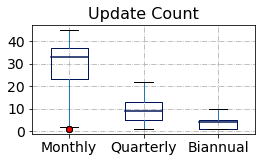

Monthly      33.0
Quarterly     9.0
Biannual      4.0
dtype: float64

<Figure size 432x288 with 0 Axes>

In [27]:
c = 'release_count'
red_circle = dict(markerfacecolor='red', marker='o')
df_plot = pd.DataFrame({'Monthly': df_final_samsung_monthly[c],
                       'Quarterly': df_final_samsung_quarterly[c],
                       'Biannual': df_final_samsung_biannual[c]})

boxprops = dict(linestyle='-', linewidth=1, color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#00145A')  # colors median line

df_plot.boxplot(figsize=(4,2),flierprops=red_circle,boxprops=boxprops,medianprops=medianprops,widths=0.5)

plt.title('Update Count',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='-.')
plt.savefig('../Results/1_spl_count_seperated.pdf', bbox_inches='tight')
plt.show()
plt.tight_layout()

df_plot.median()

### Support Duration

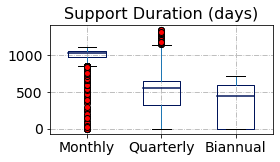

Monthly      1034.0
Quarterly     560.0
Biannual      442.0
dtype: float64

<Figure size 432x288 with 0 Axes>

In [28]:
c = 'release_date_duration'
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')
red_circle = dict(markerfacecolor='red', marker='o')
df_plot = pd.DataFrame({'Monthly': df_final_samsung_monthly[c].dt.days,
                       'Quarterly': df_final_samsung_quarterly[c].dt.days,
                       'Biannual': df_final_samsung_biannual[c].dt.days})

boxprops = dict(linestyle='-', linewidth=1, color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#00145A')  # colors median line

df_plot.boxplot(figsize=(4,2),flierprops=red_circle,boxprops=boxprops,medianprops=medianprops,widths=0.5)

plt.title('Support Duration (days)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='-.')
plt.savefig('../Results/2_spl_duration_seperated.pdf', bbox_inches='tight')
plt.show()
plt.tight_layout()

df_plot.median()

### Update Frequency

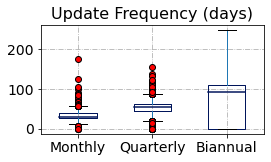

Monthly      30.342857
Quarterly    53.500000
Biannual     91.633333
dtype: float64

<Figure size 432x288 with 0 Axes>

In [29]:
c = 'avg_release_freq'
mean_shape = dict(markerfacecolor='black', marker='D', markeredgecolor='black')

red_circle = dict(markerfacecolor='red', marker='o')

df_plot = pd.DataFrame({'Monthly': df_final_samsung_monthly[c],
                       'Quarterly': df_final_samsung_quarterly[c],
                       'Biannual': df_final_samsung_biannual[c]})

boxprops = dict(linestyle='-', linewidth=1, color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#00145A')  # colors median line

df_plot.boxplot(figsize=(4,2),flierprops=red_circle,boxprops=boxprops,medianprops=medianprops,widths=0.5)

plt.title('Update Frequency (days)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='-.')
plt.savefig('../Results/3_spl_frequency_seperated.pdf', bbox_inches='tight')
plt.show()

plt.tight_layout()


df_plot.median()

### Release Delay

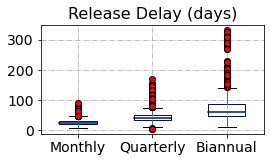

Monthly      25.0
Quarterly    42.0
Biannual     62.0
dtype: float64

<Figure size 432x288 with 0 Axes>

In [30]:
c = 'avg_release_delay'
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')
red_circle = dict(markerfacecolor='red', marker='o')

df_plot = pd.DataFrame({'Monthly': df_final_samsung_monthly[c],
                       'Quarterly': df_final_samsung_quarterly[c],
                       'Biannual': df_final_samsung_biannual[c]})
boxprops = dict(linestyle='-', linewidth=1, color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#00145A')  # colors median line

df_plot.boxplot(figsize=(4,2),flierprops=red_circle,boxprops=boxprops,medianprops=medianprops,widths=0.5)


plt.title('Release Delay (days)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='-.')
plt.savefig('../Results/4_spl_delay_seperated.pdf', bbox_inches='tight')
plt.show()

plt.tight_layout()

df_plot.median()

# 2. Geolocation Analysis

## Samsung - Monthly Maps

### Update Count

In [169]:
import pandas as pd
import numpy as np
import io
import plotly.express as px
import plotly.graph_objects as go

p = 'release_count'

values_to_plot = df_final_samsung_monthly.groupby(['iso_code'])[p].mean().sort_values(ascending=True)
avg = values_to_plot.median()

df_plot = pd.DataFrame(values_to_plot.values,columns=[p])
df_plot['country_code'] = values_to_plot.index

fig = px.choropleth(df_plot, locations="country_code",
                    locationmode='ISO-3',
                    color= p,
                    hover_name="country_code",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    range_color=(0.5*avg,1.5*avg),
                    #labels={p:'Count'}
                   )

fig.update_layout(
        width=800,
        height=600,
        coloraxis=dict(
            colorbar_nticks=6,
            colorbar_orientation='h',
            #colorbar_borderwidth = 2,
            colorbar_len=1,
            colorbar_y=+0.06,
            #colorbar_ticksuffix='days',
            colorbar_title_font_size=1,
            colorbar=dict(
                #title_side='bottom',
                tickangle=0,
                tickfont=dict(size=30, color='black'))
            )
)

layout = go.Layout(
  margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    )
)


fig.show()

fig.write_image("../Results/geolocation_monthly_count.pdf")

fig.write_html("../Results/InteractiveFigures/geolocation_monthly_count.html",full_html=False, include_plotlyjs='cdn')

print('Avg: {}'.format(avg))


Avg: 32.88955361251726


### Support Duration

In [170]:
import pandas as pd
import numpy as np
import io
import plotly.express as px

p = 'release_date_duration'

values_to_plot = df_final_samsung_monthly.groupby(['iso_code'])[p].mean().dt.days.sort_values(ascending=True)
avg = values_to_plot.median()

df_plot = pd.DataFrame(values_to_plot.values,columns=[p])
df_plot['country_code'] = values_to_plot.index

fig = px.choropleth(df_plot, locations="country_code",
                    locationmode='ISO-3',
                    color= p,
                    hover_name="country_code",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    range_color=(0.5*avg,1.5*avg))

fig.update_layout(
        width=800,
        height=600,
        coloraxis=dict(
            colorbar_nticks=6,
            colorbar_orientation='h',
            #colorbar_borderwidth = 2,
            colorbar_len=1,
            colorbar_y=+0.06,
            #colorbar_ticksuffix='days',
            colorbar_title_font_size=1,
            colorbar=dict(
                #title_side='bottom',
                tickangle=0,
                tickfont=dict(size=30, color='black'))
            )
)


layout = go.Layout(
  margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    )
)


fig.show()

fig.write_image("../Results/geolocation_monthly_duration.pdf")

fig.write_html("../Results/InteractiveFigures/geolocation_monthly_duration.html",full_html=False, include_plotlyjs='cdn')

print('Avg: {}'.format(avg))



Avg: 1012.5


### Update Frequency

In [171]:
p = 'avg_release_freq'

values_to_plot = df_final_samsung_monthly.groupby(['iso_code'])[p].mean().sort_values(ascending=True)
avg = values_to_plot.median()

df_plot = pd.DataFrame(values_to_plot.values,columns=[p])
df_plot['country_code'] = values_to_plot.index

fig = px.choropleth(df_plot, locations="country_code",
                    locationmode='ISO-3',
                    color= p,
                    hover_name="country_code",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    range_color=(0.5*avg,1.5*avg))

fig.update_layout(
        width=800,
        height=600,
        coloraxis=dict(
            colorbar_nticks=6,
            colorbar_orientation='h',
            #colorbar_borderwidth = 2,
            colorbar_len=1,
            colorbar_y=+0.06,
            #colorbar_ticksuffix=' days',
            colorbar_title_font_size=1,
            colorbar=dict(
                #title_side='bottom',
                tickangle=0,
                tickfont=dict(size=30, color='black'))
            )
)

layout = go.Layout(
  margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    )
)


fig.show()

fig.write_image("../Results/geolocation_monthly_frequency.pdf")

fig.write_html("../Results/InteractiveFigures/geolocation_monthly_frequency.html",full_html=False, include_plotlyjs='cdn')

print('Avg: {}'.format(avg))



Avg: 30.608519463533334


### Release Delay

In [172]:
p = 'avg_release_delay'

values_to_plot = df_final_samsung_monthly.groupby(['iso_code'])[p].mean().sort_values(ascending=True)
avg = values_to_plot.median()

df_plot = pd.DataFrame(values_to_plot.values,columns=[p])
df_plot['country_code'] = values_to_plot.index

fig = px.choropleth(df_plot, locations="country_code",
                    locationmode='ISO-3',
                    color= p,
                    hover_name="country_code",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    range_color=(0.5*avg,1.5*avg))

fig.update_layout(
        width=800,
        height=600,
        coloraxis=dict(
            colorbar_nticks=6,
            colorbar_orientation='h',
            #colorbar_borderwidth = 2,
            colorbar_len=1,
            colorbar_y=+0.06,
            #colorbar_ticksuffix=' days',
            colorbar_title_font_size=1,
            colorbar=dict(
                #title_side='bottom',
                tickangle=0,
                tickfont=dict(size=30, color='black'))
            )
)

layout = go.Layout(
  margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    )
)


fig.show()

fig.write_image("../Results/geolocation_monthly_delay.pdf")

fig.write_html("../Results/InteractiveFigures/geolocation_monthly_delay.html",full_html=False, include_plotlyjs='cdn')

print('Avg: {}'.format(avg))


Avg: 24.680555555555557


## Samsung - Quarterly Maps

### Update Count

In [173]:
import pandas as pd
import numpy as np
import io
import plotly.express as px
import plotly.graph_objects as go

p = 'release_count'

values_to_plot = df_final_samsung_quarterly.groupby(['iso_code'])[p].mean().sort_values(ascending=True)
avg = values_to_plot.median()

df_plot = pd.DataFrame(values_to_plot.values,columns=[p])
df_plot['country_code'] = values_to_plot.index

fig = px.choropleth(df_plot, locations="country_code",
                    locationmode='ISO-3',
                    color= p,
                    hover_name="country_code",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    range_color=(0.5*avg,1.5*avg),
                    #labels={p:'Count'}
                   )

fig.update_layout(
        width=800,
        height=600,
        coloraxis=dict(
            colorbar_nticks=6,
            colorbar_orientation='h',
            #colorbar_borderwidth = 2,
            colorbar_len=1,
            colorbar_y=+0.06,
            #colorbar_ticksuffix='days',
            colorbar_title_font_size=1,
            colorbar=dict(
                #title_side='bottom',
                tickangle=0,
                tickfont=dict(size=30, color='black'))
            )
)

layout = go.Layout(
  margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    )
)


fig.show()

fig.write_image("../Results/geolocation_quarterly_count.pdf")

fig.write_html("../Results/InteractiveFigures/geolocation_quarterly_count.html",full_html=False, include_plotlyjs='cdn')

print('Avg: {}'.format(avg))


Avg: 9.602132579650565


### Support Duration

In [174]:
import pandas as pd
import numpy as np
import io
import plotly.express as px

p = 'release_date_duration'

values_to_plot = df_final_samsung_quarterly.groupby(['iso_code'])[p].mean().dt.days.sort_values(ascending=True)
avg = values_to_plot.median()

df_plot = pd.DataFrame(values_to_plot.values,columns=[p])
df_plot['country_code'] = values_to_plot.index

fig = px.choropleth(df_plot, locations="country_code",
                    locationmode='ISO-3',
                    color= p,
                    hover_name="country_code",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    range_color=(0.5*avg,1.5*avg))

fig.update_layout(
        width=800,
        height=600,
        coloraxis=dict(
            colorbar_nticks=6,
            colorbar_orientation='h',
            #colorbar_borderwidth = 2,
            colorbar_len=1,
            colorbar_y=+0.06,
            #colorbar_ticksuffix='days',
            colorbar_title_font_size=1,
            colorbar=dict(
                #title_side='bottom',
                tickangle=0,
                tickfont=dict(size=30, color='black'))
            )
)


layout = go.Layout(
  margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    )
)


fig.show()

fig.write_image("../Results/geolocation_quarterly_duration.pdf")

fig.write_html("../Results/InteractiveFigures/geolocation_quarterly_duration.html",full_html=False, include_plotlyjs='cdn')

print('Avg: {}'.format(avg))



Avg: 498.0


### Update Frequency

In [175]:
p = 'avg_release_freq'

values_to_plot = df_final_samsung_quarterly.groupby(['iso_code'])[p].mean().sort_values(ascending=True)
avg = values_to_plot.median()

df_plot = pd.DataFrame(values_to_plot.values,columns=[p])
df_plot['country_code'] = values_to_plot.index

fig = px.choropleth(df_plot, locations="country_code",
                    locationmode='ISO-3',
                    color= p,
                    hover_name="country_code",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    range_color=(0.5*avg,1.5*avg))

fig.update_layout(
        width=800,
        height=600,
        coloraxis=dict(
            colorbar_nticks=6,
            colorbar_orientation='h',
            #colorbar_borderwidth = 2,
            colorbar_len=1,
            colorbar_y=+0.06,
            #colorbar_ticksuffix=' days',
            colorbar_title_font_size=1,
            colorbar=dict(
                #title_side='bottom',
                tickangle=0,
                tickfont=dict(size=30, color='black'))
            )
)

layout = go.Layout(
  margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    )
)


fig.show()

fig.write_image("../Results/geolocation_quarterly_frequency.pdf")

fig.write_html("../Results/InteractiveFigures/geolocation_quarterly_frequency.html",full_html=False, include_plotlyjs='cdn')

print('Avg: {}'.format(avg))



Avg: 51.92910235542551


### Release Delay

In [176]:
p = 'avg_release_delay'

values_to_plot = df_final_samsung_quarterly.groupby(['iso_code'])[p].mean().sort_values(ascending=True)
avg = values_to_plot.median()

df_plot = pd.DataFrame(values_to_plot.values,columns=[p])
df_plot['country_code'] = values_to_plot.index

fig = px.choropleth(df_plot, locations="country_code",
                    locationmode='ISO-3',
                    color= p,
                    hover_name="country_code",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    range_color=(0.5*avg,1.5*avg))

fig.update_layout(
        width=800,
        height=600,
        coloraxis=dict(
            colorbar_nticks=6,
            colorbar_orientation='h',
            #colorbar_borderwidth = 2,
            colorbar_len=1,
            colorbar_y=+0.06,
            #colorbar_ticksuffix=' days',
            colorbar_title_font_size=1,
            colorbar=dict(
                #title_side='bottom',
                tickangle=0,
                tickfont=dict(size=30, color='black'))
            )
)

layout = go.Layout(
  margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    )
)


fig.show()

fig.write_image("../Results/geolocation_quarterly_delay.pdf")

fig.write_html("../Results/InteractiveFigures/geolocation_quarterly_delay.html",full_html=False, include_plotlyjs='cdn')

print('Avg: {}'.format(avg))


Avg: 43.22135416666667


## Samsung - Biannual Maps

### Update Count

In [177]:
import pandas as pd
import numpy as np
import io
import plotly.express as px
import plotly.graph_objects as go

p = 'release_count'

values_to_plot = df_final_samsung_biannual.groupby(['iso_code'])[p].mean().sort_values(ascending=True)
avg = values_to_plot.median()

df_plot = pd.DataFrame(values_to_plot.values,columns=[p])
df_plot['country_code'] = values_to_plot.index

fig = px.choropleth(df_plot, locations="country_code",
                    locationmode='ISO-3',
                    color= p,
                    hover_name="country_code",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    range_color=(0.5*avg,1.5*avg),
                    #labels={p:'Count'}
                   )

fig.update_layout(
        width=800,
        height=600,
        coloraxis=dict(
            colorbar_nticks=6,
            colorbar_orientation='h',
            #colorbar_borderwidth = 2,
            colorbar_len=1,
            colorbar_y=+0.06,
            #colorbar_ticksuffix='days',
            colorbar_title_font_size=1,
            colorbar=dict(
                #title_side='bottom',
                tickangle=0,
                tickfont=dict(size=30, color='black'))
            )
)

layout = go.Layout(
  margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    )
)


fig.show()

fig.write_image("../Results/geolocation_biannual_count.pdf")

fig.write_html("../Results/InteractiveFigures/geolocation_biannual_count.html",full_html=False, include_plotlyjs='cdn')

print('Avg: {}'.format(avg))


Avg: 3.660919540229885


### Support Duration

In [178]:
import pandas as pd
import numpy as np
import io
import plotly.express as px

p = 'release_date_duration'

values_to_plot = df_final_samsung_biannual.groupby(['iso_code'])[p].mean().dt.days.sort_values(ascending=True)
avg = values_to_plot.median()

df_plot = pd.DataFrame(values_to_plot.values,columns=[p])
df_plot['country_code'] = values_to_plot.index

fig = px.choropleth(df_plot, locations="country_code",
                    locationmode='ISO-3',
                    color= p,
                    hover_name="country_code",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    range_color=(0.5*avg,1.5*avg))

fig.update_layout(
        width=800,
        height=600,
        coloraxis=dict(
            colorbar_nticks=6,
            colorbar_orientation='h',
            #colorbar_borderwidth = 2,
            colorbar_len=1,
            colorbar_y=+0.06,
            #colorbar_ticksuffix='days',
            colorbar_title_font_size=1,
            colorbar=dict(
                #title_side='bottom',
                tickangle=0,
                tickfont=dict(size=30, color='black'))
            )
)


layout = go.Layout(
  margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    )
)


fig.show()

fig.write_image("../Results/geolocation_biannual_duration.pdf")

fig.write_html("../Results/InteractiveFigures/geolocation_biannual_duration.html",full_html=False, include_plotlyjs='cdn')

print('Avg: {}'.format(avg))



Avg: 358.5


### Update Frequency

In [179]:
p = 'avg_release_freq'

values_to_plot = df_final_samsung_biannual.groupby(['iso_code'])[p].mean().sort_values(ascending=True)
avg = values_to_plot.median()

df_plot = pd.DataFrame(values_to_plot.values,columns=[p])
df_plot['country_code'] = values_to_plot.index

fig = px.choropleth(df_plot, locations="country_code",
                    locationmode='ISO-3',
                    color= p,
                    hover_name="country_code",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    range_color=(0.5*avg,1.5*avg))

fig.update_layout(
        width=800,
        height=600,
        coloraxis=dict(
            colorbar_nticks=6,
            colorbar_orientation='h',
            #colorbar_borderwidth = 2,
            colorbar_len=1,
            colorbar_y=+0.06,
            #colorbar_ticksuffix=' days',
            colorbar_title_font_size=1,
            colorbar=dict(
                #title_side='bottom',
                tickangle=0,
                tickfont=dict(size=30, color='black'))
            )
)

layout = go.Layout(
  margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    )
)


fig.show()

fig.write_image("../Results/geolocation_biannual_frequency.pdf")

fig.write_html("../Results/InteractiveFigures/geolocation_biannual_frequency.html",full_html=False, include_plotlyjs='cdn')

print('Avg: {}'.format(avg))



Avg: 77.35721861471862


### Release Delay

In [180]:
p = 'avg_release_delay'

values_to_plot = df_final_samsung_biannual.groupby(['iso_code'])[p].mean().sort_values(ascending=True)
avg = values_to_plot.median()

df_plot = pd.DataFrame(values_to_plot.values,columns=[p])
df_plot['country_code'] = values_to_plot.index

fig = px.choropleth(df_plot, locations="country_code",
                    locationmode='ISO-3',
                    color= p,
                    hover_name="country_code",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    range_color=(0.5*avg,1.5*avg))

fig.update_layout(
        width=800,
        height=600,
        coloraxis=dict(
            colorbar_nticks=6,
            colorbar_orientation='h',
            #colorbar_borderwidth = 2,
            colorbar_len=1,
            colorbar_y=+0.06,
            #colorbar_ticksuffix=' days',
            colorbar_title_font_size=1,
            colorbar=dict(
                #title_side='bottom',
                tickangle=0,
                tickfont=dict(size=30, color='black'))
            )
)

layout = go.Layout(
  margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    )
)


fig.show()

fig.write_image("../Results/geolocation_biannual_delay.pdf")

fig.write_html("../Results/InteractiveFigures/geolocation_biannual_delay.html",full_html=False, include_plotlyjs='cdn')

print('Avg: {}'.format(avg))


Avg: 71.48152173913044


## Samsung-Country Analysis-Top5-Bottom5

In [181]:
df_final_samsung_monthly['release_date_duration_days'] = df_final_samsung_monthly['release_date_duration'].dt.days
df_final_samsung_quarterly['release_date_duration_days'] = df_final_samsung_quarterly['release_date_duration'].dt.days
df_final_samsung_biannual['release_date_duration_days'] = df_final_samsung_biannual['release_date_duration'].dt.days

In [191]:

m_column_names=['m_count','m_duration','m_freq','m_delay']
q_column_names=['q_count','q_duration','q_freq','q_delay']
b_column_names=['b_count','b_duration','b_freq','b_delay']


df_samsung_monthly_latex= df_final_samsung_monthly.groupby(['subregion','country'],sort=True)[['release_count','release_date_duration_days','avg_release_freq','avg_release_delay']].median()
df_samsung_monthly_latex.columns=m_column_names
df_samsung_monthly_latex = df_samsung_monthly_latex.sort_values(by=m_column_names,ascending=False)

df_samsung_quarterly_latex= df_final_samsung_quarterly.groupby(['subregion','country'],sort=True)[['release_count','release_date_duration_days','avg_release_freq','avg_release_delay']].median()
df_samsung_quarterly_latex.columns=q_column_names
df_samsung_quarterly_latex = df_samsung_quarterly_latex.sort_values(by=q_column_names,ascending=False)

df_samsung_biannual_latex= df_final_samsung_biannual.groupby(['subregion','country'],sort=True)[['release_count','release_date_duration_days','avg_release_freq','avg_release_delay']].median()
df_samsung_biannual_latex.columns=b_column_names
df_samsung_biannual_latex = df_samsung_biannual_latex.sort_values(by=b_column_names,ascending=False)


sorted_monthly = df_samsung_monthly_latex.sort_values(by=m_column_names,ascending=False)
top5_monthly = sorted_monthly.head(5)
bottom5_monthly = sorted_monthly.iloc[-5:]
pd.concat([top5_monthly, bottom5_monthly])


m_count  m_duration     m_freq  \
subregion                       country                                       
Western Europe                  Luxembourg      39.0      1068.0  26.850000   
Eastern Europe                  Russia          38.0      1053.0  27.230769   
Western Europe                  Switzerland     38.0      1050.0  27.894737   
Central Asia                    Uzbekistan      38.0      1043.0  27.795884   
Southern Asia                   India           37.5      1050.0  27.279487   
Latin America and the Caribbean Honduras        17.0       978.0  55.941176   
                                Costa Rica      16.5      1041.5  56.175000   
                                Paraguay        16.0       972.0  60.187500   
                                Ecuador         16.0       929.0  48.117647   
                                Jamaica         15.0       903.0  56.437500   

                                             m_delay  
subregion                       country               
Western Europe                  Luxembourg      21.0  
Eastern Europe                  Russia          20.0  
Western Europe                  Switzerland     20.5  
Central Asia                    Uzbekistan      18.0  
Southern Asia                   India           19.5  
Latin America and the Caribbean Honduras        48.0  
                                Costa Rica      46.5  
                                Paraguay        48.0  
                                Ecuador         51.0  
                                Jamaica         52.0

In [192]:
# Sort and select for quarterly
sorted_quarterly = df_samsung_quarterly_latex.sort_values(by=q_column_names,ascending=False)
top5_quarterly = sorted_quarterly.head(5)
bottom5_quarterly = sorted_quarterly.iloc[-5:]

# print('========Quarterly=====')
pd.concat([top5_quarterly, bottom5_quarterly])


q_count  q_duration     q_freq  q_delay
subregion          country                                           
Southern Europe    Albania       15.0       645.0  40.312500     40.0
Eastern Europe     Ukraine       12.0       628.5  53.027778     36.0
South-eastern Asia Thailand      12.0       628.0  50.875000     37.5
                   Malaysia      12.0       619.0  51.721154     36.0
                   Vietnam       12.0       617.0  50.166667     35.0
Northern Europe    Sweden         5.0       313.0  50.041667     31.5
                   Norway         5.0       281.0  56.200000     34.0
Western Europe     Belgium        5.0       278.0  55.600000     27.0
Sub-Saharan Africa Mauritius      1.0         0.0   0.000000     67.0
                   Zambia         1.0         0.0   0.000000     67.0

In [193]:
# Sort and select for biannual
sorted_biannual = df_samsung_biannual_latex.sort_values(by=b_column_names,ascending=False)
top5_biannual = sorted_biannual.head(5)
bottom5_biannual = sorted_biannual.iloc[-5:]

# print('========Biannual=====')
pd.concat([top5_biannual, bottom5_biannual])


b_count  b_duration  \
subregion                       country                                       
Eastern Asia                    Hong Kong                   5.5       566.5   
Australia and New Zealand       Australia                   5.5       461.0   
Southern Europe                 Serbia                      5.0       619.0   
                                Bosnia and Herzegovina      5.0       577.0   
Southern Asia                   Bangladesh                  5.0       568.0   
Western Europe                  Belgium                     1.0         0.0   
Latin America and the Caribbean Costa Rica                  1.0         0.0   
Western Asia                    Israel                      1.0         0.0   
Northern Africa                 Algeria                     1.0         0.0   
Northern Europe                 Sweden                      1.0         0.0   

                                                            b_freq  b_delay  
subregion                       country                                      
Eastern Asia                    Hong Kong                93.214286     62.5  
Australia and New Zealand       Australia                81.071429     69.5  
Southern Europe                 Serbia                  104.800000     87.0  
                                Bosnia and Herzegovina  100.666667     78.0  
Southern Asia                   Bangladesh               93.142857     88.0  
Western Europe                  Belgium                   0.000000     81.0  
Latin America and the Caribbean Costa Rica                0.000000     77.5  
Western Asia                    Israel                    0.000000     59.0  
Northern Africa                 Algeria                   0.000000     45.0  
Northern Europe                 Sweden                    0.000000     16.0

## Xiaomi

In [198]:
df_final_xiaomi.groupby('region').mean().mean()

update_count          3.011905
support_duration    136.309595
update_frequency     38.986554
delay                30.252899
dtype: float64

In [194]:
df_final_xiaomi.groupby('region').mean()

,update_count,support_duration,update_frequency,delay
region,,,,
China,4.543860,274.403509,57.731990,28.655556
EEA,2.417582,172.142857,58.410256,35.288235
Global,3.060403,210.718121,61.782942,39.070000
India,2.486111,153.458333,51.068287,30.117188
Indonesia,2.472727,83.054545,29.321212,35.028846
Japan,2.000000,8.400000,4.200000,11.800000
Russia,2.298969,75.670103,26.913230,33.221591
Singapore,6.000000,181.000000,30.166667,NaN
Taiwan,2.272727,56.181818,20.434848,29.933962


## Oppo

In [197]:
df_final_oppo.groupby(['region']).mean()

,update_count,support_duration,update_frequency,delay
region,,,,
Africa & Middle East,6.824615,521.172308,87.878895,32.863636
Asia Pacific,8.658789,602.042836,84.980798,35.146694
Europe,9.408451,564.239437,68.172044,35.400000


In [196]:
df_final_oppo.groupby(['country']).mean()

,update_count,support_duration,update_frequency,delay
country,,,,
Algeria,6.926829,585.463415,101.329215,38.277778
Australia,7.857143,539.928571,82.050765,36.437500
Bangladesh,7.764706,592.392157,91.496593,36.968750
Cambodia,8.235294,527.264706,72.180603,34.366667
Egypt,6.338710,463.338710,77.599209,32.111111
France,11.083333,669.000000,69.914857,30.562500
India,9.964912,627.017544,81.137070,29.619048
Indonesia,8.944444,597.777778,79.675353,33.000000
Italy,9.647059,563.764706,61.314196,31.055556


# 3. Device Type Analysis

## Samsung

In [227]:
df_timelines['monthly_duration'] = pd.to_timedelta(df_timelines['monthly_duration'])
df_timelines['quarterly_duration'] = pd.to_timedelta(df_timelines['quarterly_duration'])
df_timelines['biannually_duration'] = pd.to_timedelta(df_timelines['biannually_duration'])

In [239]:
df_timelines_watch = df_timelines[df_timelines['device'].str.contains('Watch')]
df_timelines_tablet = df_timelines[df_timelines['device'].str.contains('Tab')]
df_timelines_phone = df_timelines[~(df_timelines['device'].str.contains('Watch') | df_timelines['device'].str.contains('Tab'))]

In [242]:
print('-----Monthly----')
print('phone: {}'.format(df_timelines_phone['monthly_duration'].mean()))
print('tablet: {}'.format(df_timelines_tablet['monthly_duration'].mean()))
print('watch: {}'.format(df_timelines_watch['monthly_duration'].mean()))

print('-----Quarterly----')
print('phone: {}'.format(df_timelines_phone['quarterly_duration'].mean()))
print('tablet: {}'.format(df_timelines_tablet['quarterly_duration'].mean()))
print('watch: {}'.format(df_timelines_watch['quarterly_duration'].mean()))

print('-----Biannual----')
print('phone: {}'.format(df_timelines_phone['biannually_duration'].mean()))
print('tablet: {}'.format(df_timelines_tablet['biannually_duration'].mean()))
print('watch: {}'.format(df_timelines_watch['biannually_duration'].mean()))

-----Monthly----
phone: 1044 days 03:57:27.250000
tablet: NaT
watch: NaT
-----Quarterly----
phone: 597 days 04:25:45.022471912
tablet: 450 days 16:57:47.818181816
watch: NaT
-----Biannual----
phone: 561 days 18:42:06.886363640
tablet: 477 days 01:15:04.222222224
watch: NaT


In [199]:
df_final_samsung['release_date_duration_days'] = df_final_samsung['release_date_duration'].dt.days

In [201]:
df_final_samsung[['device_type','release_count','release_date_duration_days','avg_release_freq','avg_release_delay']].groupby(['device_type']).mean()[1:]

,release_count,release_date_duration_days,avg_release_freq,avg_release_delay
device_type,,,,
smartphone,17.802914,792.524249,49.966104,130.875578
tablet,10.720165,647.828189,51.549247,225.338912
wearable,8.405722,363.280884,41.656805,39.914174


### Update Count

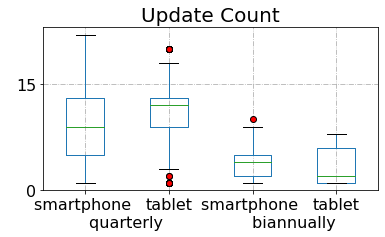

,smartphone,tablet
type,,
quarterly,9.0,12.0
biannual,4.0,2.0


<Figure size 432x288 with 0 Axes>

In [203]:
c= 'release_count'

df_plot_monthly = pd.DataFrame()
df_plot_quarterly = pd.DataFrame()
df_plot_biannual = pd.DataFrame()


#df_plot_monthly = pd.DataFrame({'type': 'monthly',
#                       'smartphone': df_monthly_features[df_monthly_features['device_type']=='smartphone'][c]})

df_plot_quarterly = pd.DataFrame({'type': 'quarterly',
                       'smartphone': df_final_samsung_quarterly[df_final_samsung_quarterly['device_type']=='smartphone'][c],
                       'tablet': df_final_samsung_quarterly[df_final_samsung_quarterly['device_type']=='tablet'][c]})

df_plot_biannual = pd.DataFrame({'type':'biannual',
                       'smartphone': df_final_samsung_biannual[df_final_samsung_biannual['device_type']=='smartphone'][c],
                       'tablet': df_final_samsung_biannual[df_final_samsung_biannual['device_type']=='tablet'][c]})


red_circle = dict(markerfacecolor='red', marker='o')
df_box=pd.concat([df_plot_monthly,df_plot_quarterly,df_plot_biannual])

grouped = df_box.groupby('type',sort=False)
grouped.boxplot(subplots=False,rot=90, fontsize=16, figsize=(6,3),flierprops=red_circle,sharex=True,sharey=True)  
plt.title('Update Count',fontsize=20)
plt.xticks([1,2,3,4],['smartphone \n                quarterly','tablet','smartphone \n                biannually','tablet'],rotation=0, ha='center',fontsize=16)
plt.yticks(fontsize=16)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(15))
plt.grid(linestyle='-.')
#plt.savefig('../Results/Figures/1_device_type_spl_count.pdf', bbox_inches='tight')
plt.show()
plt.tight_layout()

grouped.median()


### Support Duration

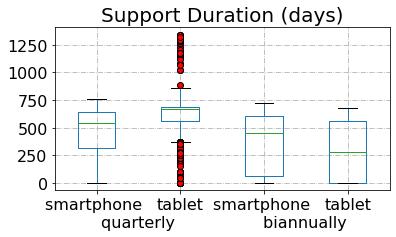

,smartphone,tablet
type,,
quarterly,543.0,668.0
biannual,450.0,276.0


<Figure size 432x288 with 0 Axes>

In [204]:
c= 'release_date_duration'

df_plot_monthly = pd.DataFrame()
df_plot_quarterly = pd.DataFrame()
df_plot_biannual = pd.DataFrame()


#df_plot_monthly = pd.DataFrame({'type': 'monthly',
#                       'smartphone': df_monthly_features[df_monthly_features['device_type']=='smartphone'][c].dt.days})

df_plot_quarterly = pd.DataFrame({'type': 'quarterly',
                       'smartphone': df_final_samsung_quarterly[df_final_samsung_quarterly['device_type']=='smartphone'][c].dt.days,
                       'tablet': df_final_samsung_quarterly[df_final_samsung_quarterly['device_type']=='tablet'][c].dt.days})

df_plot_biannual = pd.DataFrame({'type':'biannual',
                       'smartphone': df_final_samsung_biannual[df_final_samsung_biannual['device_type']=='smartphone'][c].dt.days,
                       'tablet': df_final_samsung_biannual[df_final_samsung_biannual['device_type']=='tablet'][c].dt.days})


red_circle = dict(markerfacecolor='red', marker='o')
df_box=pd.concat([df_plot_monthly,df_plot_quarterly,df_plot_biannual])

#df_box

grouped = df_box.groupby('type',sort=False)
grouped.boxplot(subplots=False,rot=90, fontsize=16, figsize=(6,3),flierprops=red_circle,sharex=True,sharey=True)  
plt.title('Support Duration (days)',fontsize=20)
plt.xticks([1,2,3,4],['smartphone \n                quarterly','tablet','smartphone \n                biannually','tablet'],rotation=0, ha='center',fontsize=16)
plt.yticks(fontsize=16)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(250))
plt.grid(linestyle='-.')
#plt.savefig('../Results/Figures/2_device_type_spl_duration.pdf', bbox_inches='tight')
plt.show()
plt.tight_layout()

grouped.median()


### Update Frequency

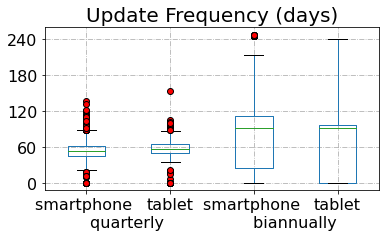

,smartphone,tablet
type,,
quarterly,53.222222,56.000000
biannual,91.666667,91.142857


<Figure size 432x288 with 0 Axes>

In [205]:

c= 'avg_release_freq'

df_plot_monthly = pd.DataFrame()
df_plot_quarterly = pd.DataFrame()
df_plot_biannual = pd.DataFrame()


#df_plot_monthly = pd.DataFrame({'type': 'monthly',
#                       'smartphone': df_monthly_features[df_monthly_features['device_type']=='smartphone'][c]})

df_plot_quarterly = pd.DataFrame({'type': 'quarterly',
                       'smartphone': df_final_samsung_quarterly[df_final_samsung_quarterly['device_type']=='smartphone'][c],
                       'tablet': df_final_samsung_quarterly[df_final_samsung_quarterly['device_type']=='tablet'][c]})

df_plot_biannual = pd.DataFrame({'type':'biannual',
                       'smartphone': df_final_samsung_biannual[df_final_samsung_biannual['device_type']=='smartphone'][c],
                       'tablet': df_final_samsung_biannual[df_final_samsung_biannual['device_type']=='tablet'][c]})


red_circle = dict(markerfacecolor='red', marker='o')
df_box=pd.concat([df_plot_monthly,df_plot_quarterly,df_plot_biannual])

grouped = df_box.groupby('type',sort=False)
grouped.boxplot(subplots=False,rot=90, fontsize=16, figsize=(6,3),flierprops=red_circle,sharex=True,sharey=True)  
plt.title('Update Frequency (days)',fontsize=20)
plt.xticks([1,2,3,4],['smartphone \n                quarterly','tablet','smartphone \n                biannually','tablet'],rotation=0, ha='center',fontsize=16)
plt.yticks(fontsize=16)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(60))
plt.grid(linestyle='-.')
#plt.savefig('../Results/Figures/3_device_type_spl_frequency.pdf', bbox_inches='tight')
plt.show()
plt.tight_layout()

grouped.median()


### Release Delay

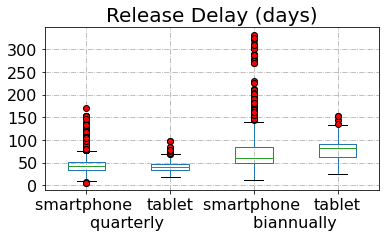

,smartphone,tablet
type,,
quarterly,42.0,40.0
biannual,60.0,82.0


<Figure size 432x288 with 0 Axes>

In [206]:

c= 'avg_release_delay'

df_plot_monthly = pd.DataFrame()
df_plot_quarterly = pd.DataFrame()
df_plot_biannual = pd.DataFrame()


#df_plot_monthly = pd.DataFrame({'type': 'monthly',
#                       'smartphone': df_monthly_features[df_monthly_features['device_type']=='smartphone'][c]})

df_plot_quarterly = pd.DataFrame({'type': 'quarterly',
                       'smartphone': df_final_samsung_quarterly[df_final_samsung_quarterly['device_type']=='smartphone'][c],
                       'tablet': df_final_samsung_quarterly[df_final_samsung_quarterly['device_type']=='tablet'][c]})

df_plot_biannual = pd.DataFrame({'type':'biannual',
                       'smartphone': df_final_samsung_biannual[df_final_samsung_biannual['device_type']=='smartphone'][c],
                       'tablet': df_final_samsung_biannual[df_final_samsung_biannual['device_type']=='tablet'][c]})


red_circle = dict(markerfacecolor='red', marker='o')
df_box=pd.concat([df_plot_monthly,df_plot_quarterly,df_plot_biannual])


grouped = df_box.groupby('type',sort=False)
grouped.boxplot(subplots=False,rot=90, fontsize=16, figsize=(6,3),flierprops=red_circle,sharex=True,sharey=True)  
plt.title('Release Delay (days)',fontsize=20)
plt.xticks([1,2,3,4],['smartphone \n                quarterly','tablet','smartphone \n                biannually','tablet'],rotation=0, ha='center',fontsize=16)
plt.yticks(fontsize=16)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(50))
plt.grid(linestyle='-.')
#plt.savefig('../Results/Figures/4_device_type_spl_delay.pdf', bbox_inches='tight')
plt.show()
plt.tight_layout()

grouped.median()


## Xiaomi

In [245]:
df_final_xiaomi[df_final_xiaomi['device_type']=='Tablet']['name'].value_counts()

Redmi Pad                 8
Xiaomi Pad 5              7
MiPad 1                   2
Xiaomi Pad 6              2
Mi Pad 3                  1
Mi Pad 4 (Plus)           1
Xiaomi Pad 5 Pro 12.4     1
Xiaomi Pad 5 Pro Wi-Fi    1
Xiaomi Pad 5 Pro 5G       1
MiPad 2                   1
Xiaomi Pad 6 Pro          1
Name: name, dtype: int64

In [246]:
len(df_final_xiaomi[df_final_xiaomi['device_type']=='Tablet']['name'].unique())

11

In [243]:
df_final_xiaomi.groupby('device_type').mean()

,update_count,support_duration,update_frequency,delay
device_type,,,,
Phone,3.009589,171.220548,48.463297,32.655594
Tablet,3.423077,159.538462,41.552747,36.071429


## Oppo

# 4. Carrier Association Analysis

## Samsung

In [270]:
condlist = [df_final_samsung_monthly['carrier']=='No-carrier', df_final_samsung_monthly['carrier']!='No-carrier']
choicelist = ['Non-carrier','Carrier-branded']
df_final_samsung_monthly['carrier_type'] = np.select(condlist, choicelist, default=0)

condlist = [df_final_samsung_quarterly['carrier']=='No-carrier', df_final_samsung_quarterly['carrier']!='No-carrier']
choicelist = ['Non-carrier','Carrier-branded']
df_final_samsung_quarterly['carrier_type'] = np.select(condlist, choicelist, default=0)

condlist = [df_final_samsung_biannual['carrier']=='No-carrier', df_final_samsung_biannual['carrier']!='No-carrier']
choicelist = ['Non-carrier','Carrier-branded']
df_final_samsung_biannual['carrier_type'] = np.select(condlist, choicelist, default=0)

In [273]:
df_final_samsung_monthly[['carrier_type','release_count','release_date_duration_days','avg_release_freq','avg_release_delay']].groupby(['carrier_type']).mean()

,release_count,release_date_duration_days,avg_release_freq,avg_release_delay
carrier_type,,,,
Carrier-branded,28.843220,989.920198,37.250816,29.004944
Non-carrier,31.763952,992.011894,33.869795,26.710623


In [274]:
df_final_samsung_quarterly[['carrier_type','release_count','release_date_duration_days','avg_release_freq','avg_release_delay']].groupby(['carrier_type']).mean()

,release_count,release_date_duration_days,avg_release_freq,avg_release_delay
carrier_type,,,,
Carrier-branded,8.844495,461.909478,52.311595,43.913710
Non-carrier,9.866954,523.792701,53.694703,43.133672


In [275]:
df_final_samsung_biannual[['carrier_type','release_count','release_date_duration_days','avg_release_freq','avg_release_delay']].groupby(['carrier_type']).mean()

,release_count,release_date_duration_days,avg_release_freq,avg_release_delay
carrier_type,,,,
Carrier-branded,3.619433,347.423077,77.710384,70.956478
Non-carrier,3.658815,353.033435,78.356289,73.000762


In [265]:
df_final_samsung['carrier'].value_counts()[:20]

No-carrier     11357
Vodafone        1093
T-Mobile         548
Claro            501
Movistar         338
Orange           291
Open Line        205
TIM              193
Kyivstar         180
MWD              170
Tigo             168
Personal         164
Nextel           159
T-mobile         155
TPH              151
PAK              146
Open             145
H3G              123
US Cellular      122
Cosmote          121
Name: carrier, dtype: int64

In [267]:
df_final_samsung[(df_final_samsung['carrier']=='Vodafone')]['country'].value_counts()

South Africa      120
Portugal           86
Italy              80
Spain              77
United Kingdom     76
Germany            70
Romania            70
Greece             70
Czech Republic     69
Ireland            61
Netherlands        59
New Zealand        55
Australia          53
Fiji               50
Cyprus             40
Hungary            40
Albania            17
Name: country, dtype: int64

In [268]:
df_final_samsung[(df_final_samsung['carrier']=='T-Mobile')]['country'].value_counts()

USA               141
Croatia            74
Czech Republic     73
Austria            72
Germany            70
Macedonia          67
Netherlands        51
Name: country, dtype: int64

In [269]:
df_final_samsung[(df_final_samsung['carrier']=='Claro')]['country'].value_counts()

Brazil       92
Argentina    91
Chile        88
Panama       78
Uruguay      77
Paraguay     75
Name: country, dtype: int64

In [263]:
df_final_samsung[['device_type','release_count','release_date_duration_days','avg_release_freq','avg_release_delay']].groupby(['device_type']).median()[1:]

,release_count,release_date_duration_days,avg_release_freq,avg_release_delay
device_type,,,,
smartphone,16.0,779.0,37.666667,41.0
tablet,11.0,626.0,45.076441,52.0
wearable,9.0,527.0,39.250000,39.0


# 5. Partnership Agreements and Platform Solutions Analysis

In [278]:
df_AER = pd.read_excel('../Data/AER-devices-all-vendors.xlsx')

df_AER_samsung = df_AER[df_AER['device'].str.contains('Samsung')].copy()
df_AER_samsung['device'] = df_AER_samsung['device'].str.replace('Samsung ', '')

df_AER_xiaomi = df_AER[df_AER['device'].str.contains('|'.join(['Xiaomi','Redmi','POCO']))].copy()
df_AER_xiaomi['device'] = df_AER_xiaomi['device'].str.replace('Xiaomi ', '')

df_AER_oppo = df_AER[df_AER['device'].str.contains('OPPO')].copy()
df_AER_oppo['device'] = df_AER_oppo['device'].str.replace('OPPO ', '')

df_AER_google = df_AER[df_AER['device'].str.contains('Pixel')].copy()
df_AER_google['device'] = df_AER_google['device'].str.replace('Google ', '')

df_AER.head()


,device,Device Type,AER validated OS version,Rugged,Security updates until,Link,AER validation date,Security update frequency
0,Zebra Technologies TC78,Phone,Android 11,Yes,October 2025,https://www.zebra.com/us/en/support-downloads/...,May 2023,Data not provided
1,Motorola moto g stylus (2023),Phone,Android 13,No,April 2026,https://en-us.support.motorola.com/app/softwar...,May 2023,Every two months
2,Pixel 7a,Phone,Android 13,No,May 2028,https://support.google.com/pixelphone/answer/4...,June 2023,Monthly
3,Handheld NAUTIZ X81,Phone,Android 12,Yes,December 2025,https://www.handheldgroup.com/aer/,March 2023,Data not provided
4,motorola edge 40,Phone,Android 13,No,January 2028,https://en-us.support.motorola.com/app/softwar...,May 2023,Every two months


In [279]:
print('Samsung AER devices: {}'.format(len(df_AER_samsung)))
print('Xiaomi AER devices: {}'.format(len(df_AER_xiaomi)))
print('Oppo AER devices: {}'.format(len(df_AER_oppo)))
print('Google AER devices: {}'.format(len(df_AER_google)))

Samsung AER devices: 60
Xiaomi AER devices: 46
Oppo AER devices: 18
Google AER devices: 20


In [ ]:
non_aer_devices = df_knox_models[df_knox_models['AER']==False]['device'].unique()

In [296]:
import pandas as pd

df_t1= pd.read_csv('../Data/Samsung/timelines_samsung_devices_v3.csv')
df_t1[['monthly_duration','quarterly_duration','biannually_duration']] = df_t1[['monthly_duration','quarterly_duration','biannually_duration']].apply(pd.to_timedelta)
df_knox_models = pd.read_csv('../Data/Samsung/knox-models-all.csv')

aer_devices = df_AER_samsung['device'].unique()

et_knox = set(df_knox_models['device'].unique())
set_AER_samsung = set(df_AER_samsung['device'].unique())

non_aer_devices = set_knox - set_AER_samsung

knox_devices= df_knox_models[df_knox_models['platform']=='Knox']['device'].unique()
others_devices= df_knox_models[df_knox_models['platform']=='Non-Knox']['device'].unique()
go_devices= df_knox_models[df_knox_models['platform']=='AndroidGo']['device'].unique()
wearos_devices= df_knox_models[df_knox_models['platform']=='WearOS']['device'].unique()



df_timelines_aer = df_t1[df_t1['device'].isin(aer_devices)].reset_index(drop=True)
df_timelines_non_aer = df_t1[df_t1['device'].isin(non_aer_devices)].reset_index(drop=True)
df_timelines_knox = df_t1[df_t1['device'].isin(knox_devices)].reset_index(drop=True)
df_timelines_others = df_t1[df_t1['device'].isin(others_devices)].reset_index(drop=True)
df_timelines_go = df_t1[df_t1['device'].isin(go_devices)].reset_index(drop=True)
df_timelines_wearos = df_t1[df_t1['device'].isin(wearos_devices)].reset_index(drop=True)


print('Total AER devices: {}'.format(len(aer_devices)))
print('Total Non-AER devices: {}'.format(len(non_aer_devices)))
print('Total Knox devices: {}'.format(len(knox_devices)))
print('Total Others devices: {}'.format(len(others_devices)))
print('Total Go devices: {}'.format(len(go_devices)))
print('Total WearOS devices: {}'.format(len(wearos_devices)))
print('=================')
print('AER devices in the support list: {}'.format(len(df_timelines_aer.index)))
print('Non-AER devices  in the support list: {}'.format(len(df_timelines_non_aer.index)))
print('Knox devices  in the support list: {}'.format(len(df_timelines_knox.index)))
print('Others devices  in the support list: {}'.format(len(df_timelines_others.index)))
print('Go devices  in the support list: {}'.format(len(df_timelines_go.index)))
print('WearOS devices  in the support list: {}'.format(len(df_timelines_wearos.index)))


Total AER devices: 60
Total Non-AER devices: 256
Total Knox devices: 259
Total Others devices: 30
Total Go devices: 5
Total WearOS devices: 7
AER devices in the support list: 49
Non-AER devices  in the support list: 159
Knox devices  in the support list: 175
Others devices  in the support list: 25
Go devices  in the support list: 4
WearOS devices  in the support list: 0


In [305]:
df_timelines_aer[df_timelines_aer['monthly_duration'].dt.days>0]

,device,monthly_start,monthly_end,quarterly_start,quarterly_end,biannually_start,biannually_end,wearable_start,wearable_end,monthly_duration,quarterly_duration,biannually_duration
0,Galaxy S10,2019-04-05 15:35:10,2022-04-03 17:02:57,2022-04-05 01:36:26,NaN,NaN,NaN,NaN,NaN,1094 days 01:27:47,NaT,NaT
1,Galaxy S10+,2019-04-05 15:35:10,2022-04-03 17:02:57,2022-04-05 01:36:26,NaN,NaN,NaN,NaN,NaN,1094 days 01:27:47,NaT,NaT
2,Galaxy S10e,2019-06-27 00:47:43,2022-04-03 17:02:57,2022-04-05 01:36:26,NaN,NaN,NaN,NaN,NaN,1011 days 16:15:14,NaT,NaT
13,Galaxy Note10,2019-10-01 12:43:14,2022-09-06 03:13:18,2022-09-07 15:36:06,NaN,NaN,NaN,NaN,NaN,1070 days 14:30:04,NaT,NaT
14,Galaxy Note10+,2019-10-01 12:43:14,2022-09-06 03:13:18,2022-09-07 15:36:06,NaN,NaN,NaN,NaN,NaN,1070 days 14:30:04,NaT,NaT
15,Galaxy Note10+ 5G,2019-10-01 12:43:14,2022-09-06 03:13:18,2022-09-07 15:36:06,NaN,NaN,NaN,NaN,NaN,1070 days 14:30:04,NaT,NaT
22,Galaxy XCover Pro,2020-03-03 11:31:08,2023-03-07 00:21:31,NaN,NaN,NaN,NaN,NaN,NaN,1098 days 12:50:23,NaT,NaT


In [306]:
df_timelines_aer[df_timelines_aer['quarterly_duration'].dt.days>0]

,device,monthly_start,monthly_end,quarterly_start,quarterly_end,biannually_start,biannually_end,wearable_start,wearable_end,monthly_duration,quarterly_duration,biannually_duration


In [307]:
df_timelines_aer[df_timelines_aer['biannually_duration'].dt.days>0]

,device,monthly_start,monthly_end,quarterly_start,quarterly_end,biannually_start,biannually_end,wearable_start,wearable_end,monthly_duration,quarterly_duration,biannually_duration


In [309]:
print('=======Monthly:')
print('aer: {}'.format(df_timelines_aer['monthly_duration'].dt.days.mean()))
print('non-aer: {}'.format(df_timelines_non_aer['monthly_duration'].dt.days.mean()))
print('knox: {}'.format(df_timelines_knox['monthly_duration'].dt.days.mean()))
print('others: {}'.format(df_timelines_others['monthly_duration'].dt.days.mean()))
print('go: {}'.format(df_timelines_go['monthly_duration'].dt.days.mean()))
print('=====Quarterly:')
print('aer: {}'.format(df_timelines_aer['quarterly_duration'].dt.days.mean()))
print('non-aer: {}'.format(df_timelines_non_aer['quarterly_duration'].dt.days.mean()))
print('knox: {}'.format(df_timelines_knox['quarterly_duration'].dt.days.mean()))
print('others: {}'.format(df_timelines_others['quarterly_duration'].dt.days.mean()))
print('go: {}'.format(df_timelines_go['quarterly_duration'].dt.days.mean()))
print('=======Biannuall:')
print('aer: {}'.format(df_timelines_aer['biannually_duration'].dt.days.mean()))
print('non-aer: {}'.format(df_timelines_non_aer['biannually_duration'].dt.days.mean()))
print('knox: {}'.format(df_timelines_knox['biannually_duration'].dt.days.mean()))
print('others: {}'.format(df_timelines_others['biannually_duration'].dt.days.mean()))
print('go: {}'.format(df_timelines_go['biannually_duration'].dt.days.mean()))

=======Monthly:
aer: 1072.4285714285713
non-aer: 1028.4166666666667
knox: 1044.6315789473683
others: nan
go: nan
=====Quarterly:
aer: nan
non-aer: 644.6813186813187
knox: 629.1111111111111
others: 700.9444444444445
go: 655.0
=======Biannuall:
aer: nan
non-aer: 576.2857142857143
knox: 594.2222222222222
others: 722.3333333333334
go: 289.0


### AER

In [298]:
df_final_samsung_monthly[['aer','release_count','release_date_duration_days','avg_release_freq','avg_release_delay']].groupby(['aer']).mean()

,release_count,release_date_duration_days,avg_release_freq,avg_release_delay
aer,,,,
False,29.255781,987.091100,37.047846,29.479663
True,31.249538,995.764325,34.103110,26.063771


In [299]:
df_final_samsung_quarterly[['aer','release_count','release_date_duration_days','avg_release_freq','avg_release_delay']].groupby(['aer']).mean()

,release_count,release_date_duration_days,avg_release_freq,avg_release_delay
aer,,,,
False,9.384605,494.599063,53.042216,43.502145


In [300]:
df_final_samsung_biannual[['aer','release_count','release_date_duration_days','avg_release_freq','avg_release_delay']].groupby(['aer']).mean()

,release_count,release_date_duration_days,avg_release_freq,avg_release_delay
aer,,,,
False,3.641927,350.627604,78.079312,72.12299


### Knox

In [301]:
df_final_samsung_monthly[['platform','release_count','release_date_duration_days','avg_release_freq','avg_release_delay']].groupby(['platform']).mean()

,release_count,release_date_duration_days,avg_release_freq,avg_release_delay
platform,,,,
Knox,30.115584,990.831407,35.777936,28.005981


In [302]:
df_final_samsung_quarterly[['platform','release_count','release_date_duration_days','avg_release_freq','avg_release_delay']].groupby(['platform']).mean()

,release_count,release_date_duration_days,avg_release_freq,avg_release_delay
platform,,,,
AndroidGo,8.134921,482.162698,58.430530,40.853175
Knox,9.161748,480.623008,52.611003,42.844743
Non-Knox,11.345062,598.685585,54.602654,48.979569


In [303]:
df_final_samsung_biannual[['platform','release_count','release_date_duration_days','avg_release_freq','avg_release_delay']].groupby(['platform']).mean()

,release_count,release_date_duration_days,avg_release_freq,avg_release_delay
platform,,,,
AndroidGo,1.867220,108.307054,36.578907,74.900415
Knox,3.824500,372.429000,81.554412,72.417126
Non-Knox,4.634921,585.492063,126.514191,52.174603


## Xiaomi 

In [320]:
xiaomi_aer_devices_unique = list(set(df_AER_xiaomi['device'].to_list()))

df_final_xiaomi_aer = df_final_xiaomi[df_final_xiaomi['name'].isin(xiaomi_aer_devices_unique)]

df_final_xiaomi_non_aer = df_final_xiaomi[~df_final_xiaomi['name'].isin(xiaomi_aer_devices_unique)]


In [318]:
len(xiaomi_aer_devices_unique)

46

In [319]:
len(df_final_xiaomi_aer)

82

In [314]:
df_AER_xiaomi.head()

,device,Device Type,AER validated OS version,Rugged,Security updates until,Link,AER validation date,Security update frequency
13,Redmi Note 12 Pro+ 5G,Phone,Android 12,No,October 2026,https://trust.mi.com/psirt/updates/phone?tab=a...,December 2022,Data not provided
14,Redmi Note 12,Phone,Android 13,No,March 2026,https://trust.mi.com/misrc/updates/phone?tab=a...,March 2023,Data not provided
16,Redmi 12C,Phone,Android 12,No,January 2027,https://trust.mi.com/psirt/updates/phone?tab=a...,December 2022,Quarterly
21,13 Lite,Phone,Android 12,No,August 2026,https://trust.mi.com/psirt/updates/phone?tab=a...,February 2023,Data not provided
22,Redmi Note 12 Pro 5G,Phone,Android 12,No,October 2026,https://trust.mi.com/psirt/updates/phone?tab=a...,December 2022,Quarterly


<AxesSubplot:>

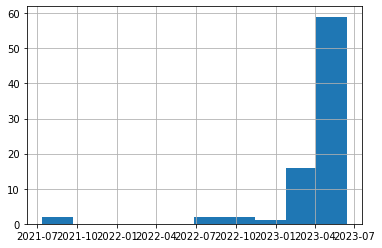

In [315]:
df_final_xiaomi_aer['last_update_date'].hist()

In [316]:
df_final_xiaomi_aer[df_final_xiaomi_aer['last_update_date']<'2022-6-13']

,codename,name,device_type,region,last_android_version,update_count,first_update_date,last_update_date,first_SPL,last_SPL,support_duration,update_frequency,delay
133,daisy_global,Mi A2 Lite,Phone,Global,10.0,2,2021-06-30,2021-07-13,NaT,NaT,13,6.5,NaN
269,jasmine_global,Mi A2,Phone,Global,10.0,2,2021-07-02,2021-07-15,NaT,NaT,13,6.5,NaN


In [317]:
len(df_final_xiaomi_aer[df_final_xiaomi_aer['last_update_date']<'2022-12-11'])

7

In [322]:
df_final_xiaomi_aer[['update_count','support_duration','update_frequency','delay']].mean()

update_count          2.487805
support_duration    175.195122
update_frequency     58.745499
delay                29.833333
dtype: float64

In [323]:
df_final_xiaomi_non_aer[['update_count','support_duration','update_frequency','delay']].mean()

update_count          3.089021
support_duration    170.286350
update_frequency     46.945768
delay                33.222330
dtype: float64

## Oppo

In [349]:
df_AER_oppo = df_AER[df_AER['device'].str.contains('OPPO')].copy()
df_AER_oppo['device'] = df_AER_oppo['device'].str.replace('OPPO ', '')

df_AER_oppo['device'] = df_AER_oppo['device'].str.split('/')
df_AER_oppo = df_AER_oppo.explode('device')

df_AER_oppo.head()

,device,Device Type,AER validated OS version,Rugged,Security updates until,Link,AER validation date,Security update frequency
19,Find N2 Flip,Phone,Android 13,No,February 2028,https://security.oppo.com/en/mend,January 2023,Quarterly
28,A78 5G,Phone,Android 13,No,February 2026,https://security.oppo.com/en/mend,January 2023,Quarterly
59,Reno8 5G,Phone,Android 12,No,August 2025,https://security.oppo.com/en/mend,January 2023,Quarterly
60,A57s,Phone,Android 12,No,August 2025,https://security.oppo.com/en/mend,June 2022,Quarterly
60,A77,Phone,Android 12,No,August 2025,https://security.oppo.com/en/mend,June 2022,Quarterly


In [356]:
len(oppo_aer_devices_unique)

23

In [358]:
oppo_aer_devices_unique

['A77 5G',
 'A72',
 'Reno8 Pro 5G',
 'Reno7 Z 5G',
 'Find X2 Lite',
 'Find X2 Pro',
 'F21 Pro',
 'Find X2 Neo',
 'A78 5G',
 'A52',
 'Find N2 Flip',
 'Find X2',
 'Find X5 Pro',
 'A77',
 'Reno8 5G',
 'Find X5 Lite',
 'Reno8 Lite 5G',
 'Find X5',
 'Reno7 5G',
 'Reno7',
 'Reno7 Lite 5G',
 'Reno3 Pro',
 'A57s']

In [351]:
oppo_aer_devices_unique = list(set(df_AER_oppo['device'].to_list()))

df_final_oppo_aer = df_final_oppo[df_final_oppo['device'].isin(oppo_aer_devices_unique)]
df_final_oppo_non_aer = df_final_oppo[~df_final_oppo['device'].isin(oppo_aer_devices_unique)]

In [352]:
df_final_oppo_aer

,url,device,country,region,last_android_version,update_count,first_update_date,last_update_date,support_duration,update_frequency,delay,ISO


In [353]:
df_final_oppo['device'].unique()

72